In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
3_5_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5257 - accuracy: 0.7620 - precision: 0.9616 - recall: 0.7714 - f1: 0.8484 - specificity: 0.6612 - negative_predictive_value: 0.2642 - matthews_correlation_coefficient: 0.3058 - val_loss: 0.4845 - val_accuracy: 0.8144 - val_precision: 0.9626 - val_recall: 0.8328 - val_f1: 0.8917 - val_specificity: 0.6392 - val_negative_predictive_value: 0.2654 - val_matthews_correlation_coefficient: 0.3207

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32073, saving model to ../models/autoencoders_requirements/blurred_2020_03_21-23_32_16.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4596 - accuracy: 0.7846 - precision: 0.9717 - recall: 0.7893 - f1: 0.8641 - specificity: 0.7203 - negative_predictive_value: 0.2808 - matthews_correlation_coefficient: 0.3509 - val_loss: 0.3873 - val_accuracy: 0.8777 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3807 - accuracy: 0.7974 - precision: 0.9811 - recall: 0.7931 - f1: 0.8732 - specificity: 0.7717 - negative_predictive_value: 0.2876 - matthews_correlation_coefficient: 0.3828 - val_loss: 0.3538 - val_accuracy: 0.8387 - val_precision: 0.9732 - val_recall: 0.8498 - val_f1: 0.9060 - val_specificity: 0.7239 - val_negative_predictive_value: 0.3211 - val_matthews_correlation_coefficient: 0.4015

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.44383
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3827 - accuracy: 0.8009 - precision: 0.9818 - recall: 0.7971 - f1: 0.8772 - specificity: 0.7954 - negative_predictive_value: 0.2860 - matthews_correlation_coefficient: 0.3896 - val_loss: 0.3803 - val_accuracy: 0.8049 - val_precision: 0.9807 - val_recall: 0.8065 - val_f1: 0.8835 - val_specificity: 0.7752 - val_negative_predictive_value: 0.2873 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.46954
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3620 - accuracy: 0.8093 - precision: 0.9827 - recall: 0.8065 - f1: 0.8831 - specificity: 0.7880 - negative_predictive_value: 0.2968 - matthews_correlation_coefficient: 0.4001 - val_loss: 0.3363 - val_accuracy: 0.8586 - val_precision: 0.9796 - val_recall: 0.8668 - val_f1: 0.9189 - val_specificity: 0.7495 - val_negative_predictive_value: 0.3465 - val_matthews_correlation_coefficient: 0.4394

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.46954
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3664 - accuracy: 0.8095 - precision: 0.9815 - recall: 0.8078 - f1: 0.8825 - specificity: 0.7643 - negative_predictive_value: 0.3006 - matthews_correlation_coefficient: 0.3928 - val_loss: 0.3396 - val_accuracy: 0.8612 - val_precision: 0.9827 - val_recall: 0.8667 - val_f1: 0.9197 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49127
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3330 - accuracy: 0.8249 - precision: 0.9863 - recall: 0.8208 - f1: 0.8934 - specificity: 0.8212 - negative_predictive_value: 0.3236 - matthews_correlation_coefficient: 0.4404 - val_loss: 0.2540 - val_accuracy: 0.8925 - val_precision: 0.9771 - val_recall: 0.9054 - val_f1: 0.9393 - val_specificity: 0.7396 - val_negative_predictive_value: 0.4190 - val_matthews_correlation_coefficient: 0.4951

Epoch 00045: val_matthews_correlation_coefficient improved from 0.49127 to 0.49513, saving model to ../models/autoencoders_requirements/blurred_2020_03_21-23_32_16.h5
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3286 - accuracy: 0.8241 - precision: 0.9870 - recall: 0.8191 - f1: 0.8923 - specificity: 0.8529 - negative_predictive_value: 0.3344 - matthews_correlation_coefficient: 0.4523 - val_loss: 0.2433 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3816 - accuracy: 0.7918 - precision: 0.9855 - recall: 0.7851 - f1: 0.8664 - specificity: 0.8201 - negative_predictive_value: 0.3094 - matthews_correlation_coefficient: 0.4155 - val_loss: 0.3043 - val_accuracy: 0.8907 - val_precision: 0.9783 - val_recall: 0.9029 - val_f1: 0.9382 - val_specificity: 0.7568 - val_negative_predictive_value: 0.4270 - val_matthews_correlation_coefficient: 0.5054

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.52546
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3345 - accuracy: 0.8230 - precision: 0.9873 - recall: 0.8169 - f1: 0.8919 - specificity: 0.8314 - negative_predictive_value: 0.3251 - matthews_correlation_coefficient: 0.4439 - val_loss: 0.3677 - val_accuracy: 0.8404 - val_precision: 0.9840 - val_recall: 0.8424 - val_f1: 0.9064 - val_specificity: 0.8072 - val_negative_predictive_value: 0.3397 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.54126
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3030 - accuracy: 0.8447 - precision: 0.9863 - recall: 0.8397 - f1: 0.9035 - specificity: 0.8377 - negative_predictive_value: 0.3576 - matthews_correlation_coefficient: 0.4770 - val_loss: 0.2991 - val_accuracy: 0.8560 - val_precision: 0.9836 - val_recall: 0.8599 - val_f1: 0.9167 - val_specificity: 0.7995 - val_negative_predictive_value: 0.3516 - val_matthews_correlation_coefficient: 0.4618

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.54126
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3181 - accuracy: 0.8293 - precision: 0.9895 - recall: 0.8235 - f1: 0.8956 - specificity: 0.8490 - negative_predictive_value: 0.3468 - matthews_correlation_coefficient: 0.4699 - val_loss: 0.3886 - val_accuracy: 0.8144 - val_precision: 0.9869 - val_recall: 0.8116 - val_f1: 0.8892 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.55650
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2972 - accuracy: 0.8547 - precision: 0.9882 - recall: 0.8523 - f1: 0.9136 - specificity: 0.8475 - negative_predictive_value: 0.3721 - matthews_correlation_coefficient: 0.4932 - val_loss: 0.2406 - val_accuracy: 0.9011 - val_precision: 0.9710 - val_recall: 0.9211 - val_f1: 0.9447 - val_specificity: 0.6716 - val_negative_predictive_value: 0.4479 - val_matthews_correlation_coefficient: 0.4897

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.55650
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2932 - accuracy: 0.8497 - precision: 0.9900 - recall: 0.8442 - f1: 0.9097 - specificity: 0.8775 - negative_predictive_value: 0.3611 - matthews_correlation_coefficient: 0.4949 - val_loss: 0.2171 - val_accuracy: 0.9133 - val_precision: 0.9760 - val_recall: 0.9293 - val_f1: 0.9516 - val_spe

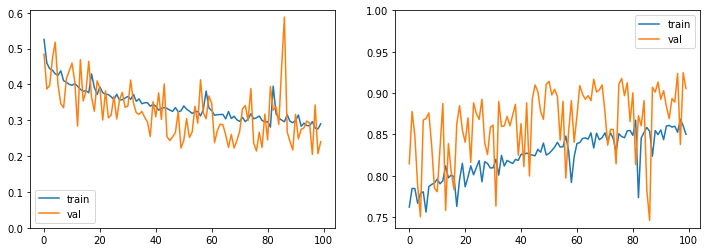

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6670 - accuracy: 0.5857 - precision: 0.7881 - recall: 0.5570 - f1: 0.6269 - specificity: 0.6404 - negative_predictive_value: 0.4043 - matthews_correlation_coefficient: 0.1942 - val_loss: 0.6550 - val_accuracy: 0.5811 - val_precision: 0.7754 - val_recall: 0.5150 - val_f1: 0.6155 - val_specificity: 0.6621 - val_negative_predictive_value: 0.3800 - val_matthews_correlation_coefficient: 0.1924

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19240, saving model to ../models/autoencoders_requirements/looking_away_2020_03_21-23_47_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6557 - accuracy: 0.6278 - precision: 0.7883 - recall: 0.6378 - f1: 0.6961 - specificity: 0.6229 - negative_predictive_value: 0.4438 - matthews_correlation_coefficient: 0.2450 - val_loss: 0.6653 - val_accuracy: 0.5794 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6158 - accuracy: 0.6733 - precision: 0.8171 - recall: 0.6867 - f1: 0.7346 - specificity: 0.6534 - negative_predictive_value: 0.4865 - matthews_correlation_coefficient: 0.3217 - val_loss: 0.5682 - val_accuracy: 0.7268 - val_precision: 0.7630 - val_recall: 0.8062 - val_f1: 0.7805 - val_specificity: 0.5027 - val_negative_predictive_value: 0.5738 - val_matthews_correlation_coefficient: 0.3206

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33709
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6097 - accuracy: 0.6766 - precision: 0.8282 - recall: 0.6753 - f1: 0.7363 - specificity: 0.6709 - negative_predictive_value: 0.4830 - matthews_correlation_coefficient: 0.3271 - val_loss: 0.5699 - val_accuracy: 0.7069 - val_precision: 0.7578 - val_recall: 0.7769 - val_f1: 0.7630 - val_specificity: 0.5050 - val_negative_predictive_value: 0.5356 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient improved from 0.35797 to 0.37496, saving model to ../models/autoencoders_requirements/looking_away_2020_03_21-23_47_02.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5749 - accuracy: 0.7061 - precision: 0.8256 - recall: 0.7196 - f1: 0.7631 - specificity: 0.6687 - negative_predictive_value: 0.5240 - matthews_correlation_coefficient: 0.3669 - val_loss: 0.5705 - val_accuracy: 0.7103 - val_precision: 0.8072 - val_recall: 0.7092 - val_f1: 0.7516 - val_specificity: 0.6636 - val_negative_predictive_value: 0.5243 - val_matthews_correlation_coefficient: 0.3505

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37496
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5747 - accuracy: 0.6961 - precision: 0.8399 - recall: 0.6990 - f1: 0.7561 - specificity: 0.6975 - negative_predictive_value: 0.5132 - matthews_correlation_coefficient: 0.3731 - val_loss: 0.6299 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5502 - accuracy: 0.7156 - precision: 0.8427 - recall: 0.7158 - f1: 0.7684 - specificity: 0.7040 - negative_predictive_value: 0.5327 - matthews_correlation_coefficient: 0.3960 - val_loss: 0.5733 - val_accuracy: 0.6921 - val_precision: 0.8194 - val_recall: 0.6630 - val_f1: 0.7275 - val_specificity: 0.7121 - val_negative_predictive_value: 0.5090 - val_matthews_correlation_coefficient: 0.3497

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38109
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5522 - accuracy: 0.7121 - precision: 0.8469 - recall: 0.7199 - f1: 0.7718 - specificity: 0.7053 - negative_predictive_value: 0.5376 - matthews_correlation_coefficient: 0.4029 - val_loss: 0.6020 - val_accuracy: 0.6782 - val_precision: 0.8395 - val_recall: 0.6181 - val_f1: 0.7080 - val_specificity: 0.7586 - val_negative_predictive_value: 0.4876 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.39035
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5424 - accuracy: 0.7260 - precision: 0.8600 - recall: 0.7267 - f1: 0.7804 - specificity: 0.7169 - negative_predictive_value: 0.5425 - matthews_correlation_coefficient: 0.4223 - val_loss: 0.6329 - val_accuracy: 0.6531 - val_precision: 0.8268 - val_recall: 0.5839 - val_f1: 0.6789 - val_specificity: 0.7583 - val_negative_predictive_value: 0.4680 - val_matthews_correlation_coefficient: 0.3165

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39035
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5324 - accuracy: 0.7271 - precision: 0.8544 - recall: 0.7299 - f1: 0.7795 - specificity: 0.7292 - negative_predictive_value: 0.5481 - matthews_correlation_coefficient: 0.4297 - val_loss: 0.6167 - val_accuracy: 0.6713 - val_precision: 0.8252 - val_recall: 0.6152 - val_f1: 0.7010 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.39035
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5318 - accuracy: 0.7252 - precision: 0.8581 - recall: 0.7126 - f1: 0.7715 - specificity: 0.7370 - negative_predictive_value: 0.5430 - matthews_correlation_coefficient: 0.4299 - val_loss: 0.6249 - val_accuracy: 0.6375 - val_precision: 0.8441 - val_recall: 0.5438 - val_f1: 0.6546 - val_specificity: 0.8099 - val_negative_predictive_value: 0.4617 - val_matthews_correlation_coefficient: 0.3270

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39035
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5339 - accuracy: 0.7126 - precision: 0.8602 - recall: 0.7045 - f1: 0.7640 - specificity: 0.7210 - negative_predictive_value: 0.5353 - matthews_correlation_coefficient: 0.4101 - val_loss: 0.5776 - val_accuracy: 0.6904 - val_precision: 0.8269 - val_recall: 0.6483 - val_f1: 0.7233 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.39200
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5219 - accuracy: 0.7382 - precision: 0.8700 - recall: 0.7412 - f1: 0.7933 - specificity: 0.7434 - negative_predictive_value: 0.5608 - matthews_correlation_coefficient: 0.4548 - val_loss: 0.5630 - val_accuracy: 0.7138 - val_precision: 0.8348 - val_recall: 0.6828 - val_f1: 0.7472 - val_specificity: 0.7273 - val_negative_predictive_value: 0.5247 - val_matthews_correlation_coefficient: 0.3830

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39200
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5129 - accuracy: 0.7416 - precision: 0.8634 - recall: 0.7447 - f1: 0.7952 - specificity: 0.7339 - negative_predictive_value: 0.5606 - matthews_correlation_coefficient: 0.4489 - val_loss: 0.5451 - val_accuracy: 0.7190 - val_precision: 0.8131 - val_recall: 0.7189 - val_f1: 0.7592 - val_spe

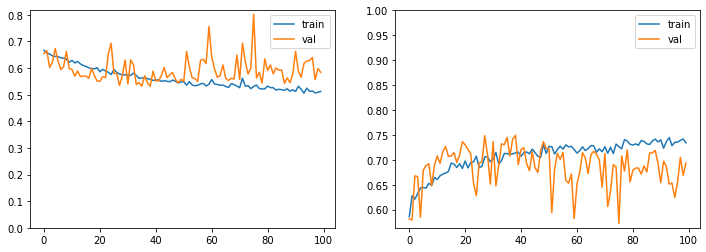

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6385 - accuracy: 0.6354 - precision: 0.6985 - recall: 0.6255 - f1: 0.6356 - specificity: 0.6514 - negative_predictive_value: 0.5833 - matthews_correlation_coefficient: 0.2851 - val_loss: 0.5865 - val_accuracy: 0.7225 - val_precision: 0.6916 - val_recall: 0.8591 - val_f1: 0.7626 - val_specificity: 0.5041 - val_negative_predictive_value: 0.7550 - val_matthews_correlation_coefficient: 0.4008

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40082, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_22-00_01_42.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5929 - accuracy: 0.7072 - precision: 0.7414 - recall: 0.7533 - f1: 0.7393 - specificity: 0.6425 - negative_predictive_value: 0.6609 - matthews_correlation_coefficient: 0.3998 - val_loss: 0.6432 - val_accuracy: 0.6271 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.51471
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4867 - accuracy: 0.7738 - precision: 0.7759 - recall: 0.8477 - f1: 0.8051 - specificity: 0.6643 - negative_predictive_value: 0.7575 - matthews_correlation_coefficient: 0.5286 - val_loss: 0.5195 - val_accuracy: 0.7199 - val_precision: 0.8057 - val_recall: 0.6397 - val_f1: 0.7071 - val_specificity: 0.8169 - val_negative_predictive_value: 0.6355 - val_matthews_correlation_coefficient: 0.4483

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.51471
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7714 - precision: 0.7850 - recall: 0.8412 - f1: 0.8061 - specificity: 0.6793 - negative_predictive_value: 0.7618 - matthews_correlation_coefficient: 0.5327 - val_loss: 0.4941 - val_accuracy: 0.7528 - val_precision: 0.7834 - val_recall: 0.7388 - val_f1: 0.7559 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4508 - accuracy: 0.7918 - precision: 0.8079 - recall: 0.8506 - f1: 0.8234 - specificity: 0.7161 - negative_predictive_value: 0.7758 - matthews_correlation_coefficient: 0.5743 - val_loss: 0.4575 - val_accuracy: 0.7901 - val_precision: 0.7720 - val_recall: 0.8458 - val_f1: 0.8035 - val_specificity: 0.6896 - val_negative_predictive_value: 0.7829 - val_matthews_correlation_coefficient: 0.5445

Epoch 00029: val_matthews_correlation_coefficient improved from 0.53651 to 0.54455, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_22-00_01_42.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4610 - accuracy: 0.7846 - precision: 0.7981 - recall: 0.8442 - f1: 0.8147 - specificity: 0.7015 - negative_predictive_value: 0.7592 - matthews_correlation_coefficient: 0.5526 - val_loss: 0.4601 - val_accuracy: 0.7875 - val_precision: 0.7719 - val_recall: 0.8433 - val_f1: 0.8019 - 


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.54455
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4365 - accuracy: 0.8002 - precision: 0.8262 - recall: 0.8430 - f1: 0.8278 - specificity: 0.7368 - negative_predictive_value: 0.7708 - matthews_correlation_coefficient: 0.5877 - val_loss: 0.4796 - val_accuracy: 0.7710 - val_precision: 0.7623 - val_recall: 0.8276 - val_f1: 0.7885 - val_specificity: 0.6737 - val_negative_predictive_value: 0.7547 - val_matthews_correlation_coefficient: 0.5082

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.54455
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4395 - accuracy: 0.8000 - precision: 0.8148 - recall: 0.8564 - f1: 0.8307 - specificity: 0.7274 - negative_predictive_value: 0.7869 - matthews_correlation_coefficient: 0.5921 - val_loss: 0.4539 - val_accuracy: 0.7944 - val_precision: 0.7793 - val_recall: 0.8455 - val_f1: 0.8073 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4169 - accuracy: 0.8067 - precision: 0.8223 - recall: 0.8444 - f1: 0.8284 - specificity: 0.7521 - negative_predictive_value: 0.7812 - matthews_correlation_coefficient: 0.6011 - val_loss: 0.4507 - val_accuracy: 0.7858 - val_precision: 0.8011 - val_recall: 0.7853 - val_f1: 0.7896 - val_specificity: 0.7623 - val_negative_predictive_value: 0.7368 - val_matthews_correlation_coefficient: 0.5423

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.56374
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4295 - accuracy: 0.8009 - precision: 0.8200 - recall: 0.8447 - f1: 0.8267 - specificity: 0.7380 - negative_predictive_value: 0.7705 - matthews_correlation_coefficient: 0.5877 - val_loss: 0.4763 - val_accuracy: 0.7754 - val_precision: 0.8135 - val_recall: 0.7461 - val_f1: 0.7747 - val_specificity: 0.7923 - val_negative_predictive_value: 0.7083 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4160 - accuracy: 0.8065 - precision: 0.8322 - recall: 0.8413 - f1: 0.8314 - specificity: 0.7502 - negative_predictive_value: 0.7716 - matthews_correlation_coefficient: 0.5986 - val_loss: 0.4838 - val_accuracy: 0.7693 - val_precision: 0.8012 - val_recall: 0.7491 - val_f1: 0.7708 - val_specificity: 0.7783 - val_negative_predictive_value: 0.7063 - val_matthews_correlation_coefficient: 0.5169

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.56374
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4224 - accuracy: 0.8106 - precision: 0.8236 - recall: 0.8488 - f1: 0.8310 - specificity: 0.7560 - negative_predictive_value: 0.7890 - matthews_correlation_coefficient: 0.6097 - val_loss: 0.4884 - val_accuracy: 0.7728 - val_precision: 0.8032 - val_recall: 0.7530 - val_f1: 0.7737 - val_specificity: 0.7793 - val_negative_predictive_value: 0.7130 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.57518
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4103 - accuracy: 0.8124 - precision: 0.8404 - recall: 0.8421 - f1: 0.8358 - specificity: 0.7745 - negative_predictive_value: 0.7816 - matthews_correlation_coefficient: 0.6186 - val_loss: 0.4536 - val_accuracy: 0.7849 - val_precision: 0.7895 - val_recall: 0.8068 - val_f1: 0.7937 - val_specificity: 0.7342 - val_negative_predictive_value: 0.7502 - val_matthews_correlation_coefficient: 0.5400

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.57518
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4098 - accuracy: 0.8119 - precision: 0.8327 - recall: 0.8530 - f1: 0.8384 - specificity: 0.7603 - negative_predictive_value: 0.7857 - matthews_correlation_coefficient: 0.6153 - val_loss: 0.5302 - val_accuracy: 0.7433 - val_precision: 0.8090 - val_recall: 0.6842 - val_f1: 0.7359 - val_spe

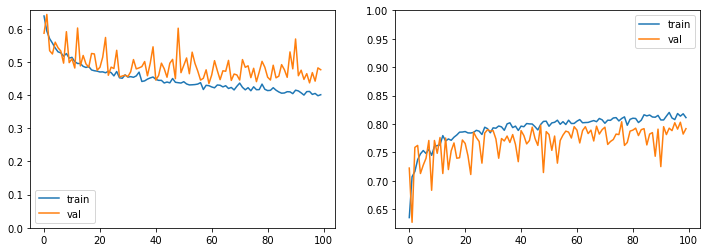

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5786 - accuracy: 0.7384 - precision: 0.9699 - recall: 0.7433 - f1: 0.8293 - specificity: 0.5990 - negative_predictive_value: 0.1862 - matthews_correlation_coefficient: 0.2341 - val_loss: 0.7257 - val_accuracy: 0.5958 - val_precision: 0.9621 - val_recall: 0.5544 - val_f1: 0.6995 - val_specificity: 0.8369 - val_negative_predictive_value: 0.1563 - val_matthews_correlation_coefficient: 0.2163

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21628, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_22-00_16_20.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4807 - accuracy: 0.7772 - precision: 0.9783 - recall: 0.7810 - f1: 0.8621 - specificity: 0.7268 - negative_predictive_value: 0.2437 - matthews_correlation_coefficient: 0.3269 - val_loss: 0.5584 - val_accuracy: 0.7528 - val_precisi


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35903
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3606 - accuracy: 0.8271 - precision: 0.9853 - recall: 0.8281 - f1: 0.8967 - specificity: 0.7813 - negative_predictive_value: 0.3023 - matthews_correlation_coefficient: 0.4068 - val_loss: 0.3501 - val_accuracy: 0.8369 - val_precision: 0.9534 - val_recall: 0.8196 - val_f1: 0.8787 - val_specificity: 0.7041 - val_negative_predictive_value: 0.2936 - val_matthews_correlation_coefficient: 0.3458

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35903
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3607 - accuracy: 0.8310 - precision: 0.9837 - recall: 0.8300 - f1: 0.8969 - specificity: 0.7560 - negative_predictive_value: 0.2926 - matthews_correlation_coefficient: 0.3961 - val_loss: 0.5208 - val_accuracy: 0.7450 - val_precision: 0.9611 - val_recall: 0.7151 - val_f1: 0.8167 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3461 - accuracy: 0.8427 - precision: 0.9847 - recall: 0.8457 - f1: 0.9077 - specificity: 0.7223 - negative_predictive_value: 0.3030 - matthews_correlation_coefficient: 0.4010 - val_loss: 0.4699 - val_accuracy: 0.7832 - val_precision: 0.9585 - val_recall: 0.7570 - val_f1: 0.8424 - val_specificity: 0.7626 - val_negative_predictive_value: 0.2365 - val_matthews_correlation_coefficient: 0.3096

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38805
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3211 - accuracy: 0.8505 - precision: 0.9889 - recall: 0.8502 - f1: 0.9119 - specificity: 0.7569 - negative_predictive_value: 0.3102 - matthews_correlation_coefficient: 0.4189 - val_loss: 0.3766 - val_accuracy: 0.8283 - val_precision: 0.9582 - val_recall: 0.8053 - val_f1: 0.8721 - val_specificity: 0.7378 - val_negative_predictive_value: 0.2858 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39314
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3016 - accuracy: 0.8518 - precision: 0.9904 - recall: 0.8504 - f1: 0.9134 - specificity: 0.8032 - negative_predictive_value: 0.3229 - matthews_correlation_coefficient: 0.4460 - val_loss: 0.4270 - val_accuracy: 0.7936 - val_precision: 0.9585 - val_recall: 0.7684 - val_f1: 0.8498 - val_specificity: 0.7626 - val_negative_predictive_value: 0.2531 - val_matthews_correlation_coefficient: 0.3245

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39314
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3134 - accuracy: 0.8445 - precision: 0.9872 - recall: 0.8448 - f1: 0.9073 - specificity: 0.7767 - negative_predictive_value: 0.3178 - matthews_correlation_coefficient: 0.4287 - val_loss: 0.4180 - val_accuracy: 0.7892 - val_precision: 0.9630 - val_recall: 0.7603 - val_f1: 0.8461 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39314
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2942 - accuracy: 0.8620 - precision: 0.9879 - recall: 0.8628 - f1: 0.9194 - specificity: 0.7943 - negative_predictive_value: 0.3259 - matthews_correlation_coefficient: 0.4448 - val_loss: 0.3520 - val_accuracy: 0.8248 - val_precision: 0.9594 - val_recall: 0.8010 - val_f1: 0.8704 - val_specificity: 0.7626 - val_negative_predictive_value: 0.2841 - val_matthews_correlation_coefficient: 0.3592

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39314
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2815 - accuracy: 0.8683 - precision: 0.9904 - recall: 0.8677 - f1: 0.9234 - specificity: 0.8127 - negative_predictive_value: 0.3410 - matthews_correlation_coefficient: 0.4650 - val_loss: 0.3679 - val_accuracy: 0.8231 - val_precision: 0.9602 - val_recall: 0.7982 - val_f1: 0.8691 - val_spe

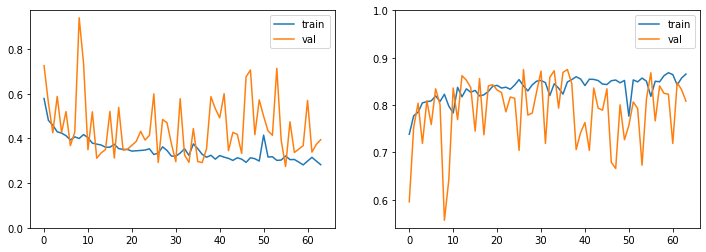

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5794 - accuracy: 0.8380 - precision: 0.9965 - recall: 0.8419 - f1: 0.9072 - specificity: 0.0966 - negative_predictive_value: 0.0209 - matthews_correlation_coefficient: 0.0391 - val_loss: 0.4374 - val_accuracy: 0.6956 - val_precision: 1.0000 - val_recall: 0.7013 - val_f1: 0.8219 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0196 - val_matthews_correlation_coefficient: 0.0498

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04979, saving model to ../models/autoencoders_requirements/washed_out_2020_03_22-00_25_49.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5529 - accuracy: 0.7304 - precision: 0.9916 - recall: 0.7318 - f1: 0.8147 - specificity: 0.1448 - negative_predictive_value: 0.0173 - matthews_correlation_coefficient: 0.0383 - val_loss: 0.2428 - val_accuracy: 0.8335 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1010 - accuracy: 0.9566 - precision: 0.9998 - recall: 0.9568 - f1: 0.9767 - specificity: 0.1862 - negative_predictive_value: 0.1069 - matthews_correlation_coefficient: 0.1346 - val_loss: 0.0557 - val_accuracy: 0.9809 - val_precision: 1.0000 - val_recall: 0.9813 - val_f1: 0.9905 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1396 - val_matthews_correlation_coefficient: 0.1592

Epoch 00015: val_matthews_correlation_coefficient improved from 0.14724 to 0.15918, saving model to ../models/autoencoders_requirements/washed_out_2020_03_22-00_25_49.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0902 - accuracy: 0.9649 - precision: 0.9998 - recall: 0.9651 - f1: 0.9814 - specificity: 0.1931 - negative_predictive_value: 0.1379 - matthews_correlation_coefficient: 0.1571 - val_loss: 0.1778 - val_accuracy: 0.9124 - val_precision: 1.0000 - val_recall: 0.9141 - val_f1: 0.9545 - val_speci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.0480 - accuracy: 0.9850 - precision: 0.9998 - recall: 0.9852 - f1: 0.9923 - specificity: 0.1897 - negative_predictive_value: 0.1529 - matthews_correlation_coefficient: 0.1655 - val_loss: 0.2847 - val_accuracy: 0.8751 - val_precision: 1.0000 - val_recall: 0.8774 - val_f1: 0.9337 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0383 - val_matthews_correlation_coefficient: 0.0776

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0612 - accuracy: 0.9659 - precision: 1.0000 - recall: 0.9659 - f1: 0.9821 - specificity: 0.2000 - negative_predictive_value: 0.1332 - matthews_correlation_coefficient: 0.1550 - val_loss: 0.0510 - val_accuracy: 0.9766 - val_precision: 1.0000 - val_recall: 0.9771 - val_f1: 0.9882 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1306 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.0664 - accuracy: 0.9681 - precision: 1.0000 - recall: 0.9682 - f1: 0.9830 - specificity: 0.2000 - negative_predictive_value: 0.1482 - matthews_correlation_coefficient: 0.1664 - val_loss: 0.1600 - val_accuracy: 0.9436 - val_precision: 1.0000 - val_recall: 0.9447 - val_f1: 0.9712 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0842 - val_matthews_correlation_coefficient: 0.1186

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1208 - accuracy: 0.9447 - precision: 0.9998 - recall: 0.9451 - f1: 0.9686 - specificity: 0.2000 - negative_predictive_value: 0.1680 - matthews_correlation_coefficient: 0.1774 - val_loss: 0.0578 - val_accuracy: 0.9775 - val_precision: 1.0000 - val_recall: 0.9779 - val_f1: 0.9886 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1396 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.18096
Epoch 00058: early stopping

   Final Accuracy:  99.39%
  Final Precision: 100.00%
     Final Recall:  99.39%
  Final F-measure:  99.69%
Final Specificity: 100.00%
        Final NPV:  53.33%
        Final MCC:  72.81%
[[   8    0]
 [   7 1138]]
              precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.99      1.00      1145

    accuracy                           0.99      1153
   macro avg       0.77      1.00      0.85      1153
weighted avg       1.00      0.99      0.99      1153



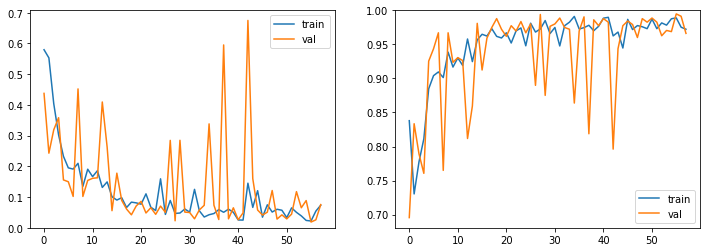

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6668 - accuracy: 0.5902 - precision: 0.9318 - recall: 0.5892 - f1: 0.7017 - specificity: 0.5181 - negative_predictive_value: 0.1002 - matthews_correlation_coefficient: 0.0950 - val_loss: 0.8030 - val_accuracy: 0.4657 - val_precision: 0.9419 - val_recall: 0.4295 - val_f1: 0.5849 - val_specificity: 0.7117 - val_negative_predictive_value: 0.0907 - val_matthews_correlation_coefficient: 0.1123

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11230, saving model to ../models/autoencoders_requirements/pixelation_2020_03_22-00_34_27.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6349 - accuracy: 0.6232 - precision: 0.9705 - recall: 0.6155 - f1: 0.7416 - specificity: 0.6351 - negative_predictive_value: 0.1270 - matthews_correlation_coefficient: 0.1689 - val_loss: 0.6215 - val_accuracy: 0.6340 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.24159
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5010 - accuracy: 0.7072 - precision: 0.9794 - recall: 0.7033 - f1: 0.8155 - specificity: 0.6935 - negative_predictive_value: 0.1626 - matthews_correlation_coefficient: 0.2417 - val_loss: 0.3257 - val_accuracy: 0.8664 - val_precision: 0.9557 - val_recall: 0.9020 - val_f1: 0.9271 - val_specificity: 0.3725 - val_negative_predictive_value: 0.1954 - val_matthews_correlation_coefficient: 0.1989

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.24159
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5027 - accuracy: 0.6931 - precision: 0.9802 - recall: 0.6876 - f1: 0.8045 - specificity: 0.7044 - negative_predictive_value: 0.1562 - matthews_correlation_coefficient: 0.2334 - val_loss: 0.2785 - val_accuracy: 0.9003 - val_precision: 0.9544 - val_recall: 0.9413 - val_f1: 0.9468 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4697 - accuracy: 0.7299 - precision: 0.9834 - recall: 0.7253 - f1: 0.8316 - specificity: 0.6922 - negative_predictive_value: 0.1809 - matthews_correlation_coefficient: 0.2696 - val_loss: 0.4174 - val_accuracy: 0.7537 - val_precision: 0.9698 - val_recall: 0.7666 - val_f1: 0.8537 - val_specificity: 0.5824 - val_negative_predictive_value: 0.1643 - val_matthews_correlation_coefficient: 0.2174

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.25462
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4693 - accuracy: 0.7206 - precision: 0.9837 - recall: 0.7149 - f1: 0.8245 - specificity: 0.7574 - negative_predictive_value: 0.1774 - matthews_correlation_coefficient: 0.2771 - val_loss: 0.3718 - val_accuracy: 0.7910 - val_precision: 0.9674 - val_recall: 0.8086 - val_f1: 0.8789 - val_specificity: 0.5477 - val_negative_predictive_value: 0.1734 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4999 - accuracy: 0.7371 - precision: 0.9784 - recall: 0.7357 - f1: 0.8369 - specificity: 0.6641 - negative_predictive_value: 0.1716 - matthews_correlation_coefficient: 0.2478 - val_loss: 0.2871 - val_accuracy: 0.8968 - val_precision: 0.9471 - val_recall: 0.9446 - val_f1: 0.9450 - val_specificity: 0.2360 - val_negative_predictive_value: 0.2261 - val_matthews_correlation_coefficient: 0.1724

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.25462
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4843 - accuracy: 0.7401 - precision: 0.9812 - recall: 0.7378 - f1: 0.8391 - specificity: 0.7117 - negative_predictive_value: 0.1816 - matthews_correlation_coefficient: 0.2699 - val_loss: 0.3813 - val_accuracy: 0.7901 - val_precision: 0.9650 - val_recall: 0.8096 - val_f1: 0.8783 - val_specificity: 0.5275 - val_negative_predictive_value: 0.1697 - val_matthews_correlation_coefficie

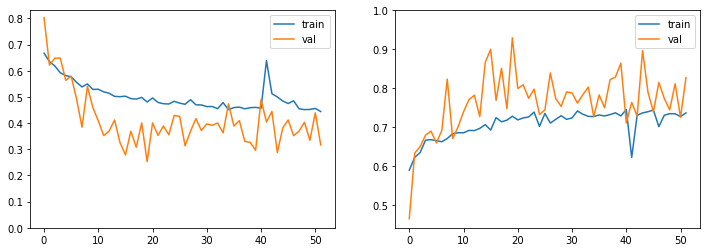

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5240 - accuracy: 0.6805 - precision: 0.9758 - recall: 0.6628 - f1: 0.7816 - specificity: 0.8570 - negative_predictive_value: 0.2503 - matthews_correlation_coefficient: 0.3359 - val_loss: 0.5707 - val_accuracy: 0.6375 - val_precision: 0.9544 - val_recall: 0.5877 - val_f1: 0.7246 - val_specificity: 0.8649 - val_negative_predictive_value: 0.2385 - val_matthews_correlation_coefficient: 0.2917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29168, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_22-00_42_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4995 - accuracy: 0.6644 - precision: 0.9838 - recall: 0.6361 - f1: 0.7676 - specificity: 0.8836 - negative_predictive_value: 0.2371 - matthews_correlation_coefficient: 0.3333 - val_loss: 0.4455 - val_accuracy: 0.7016 - val_preci


Epoch 00014: val_matthews_correlation_coefficient improved from 0.41777 to 0.45536, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_22-00_42_11.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3798 - accuracy: 0.8269 - precision: 0.9838 - recall: 0.8206 - f1: 0.8923 - specificity: 0.8750 - negative_predictive_value: 0.3810 - matthews_correlation_coefficient: 0.4939 - val_loss: 0.5243 - val_accuracy: 0.7710 - val_precision: 0.9552 - val_recall: 0.7375 - val_f1: 0.8300 - val_specificity: 0.8795 - val_negative_predictive_value: 0.3301 - val_matthews_correlation_coefficient: 0.4106

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45536
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3789 - accuracy: 0.8236 - precision: 0.9829 - recall: 0.8185 - f1: 0.8903 - specificity: 0.8605 - negative_predictive_value: 0.3888 - matthews_correlation_coefficient: 0.4918 - val_loss: 0.42

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3588 - accuracy: 0.8419 - precision: 0.9824 - recall: 0.8392 - f1: 0.9026 - specificity: 0.8440 - negative_predictive_value: 0.4105 - matthews_correlation_coefficient: 0.5094 - val_loss: 0.3104 - val_accuracy: 0.8682 - val_precision: 0.9402 - val_recall: 0.8602 - val_f1: 0.8973 - val_specificity: 0.7178 - val_negative_predictive_value: 0.4569 - val_matthews_correlation_coefficient: 0.4716

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.47928
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3552 - accuracy: 0.8445 - precision: 0.9838 - recall: 0.8410 - f1: 0.9043 - specificity: 0.8645 - negative_predictive_value: 0.4305 - matthews_correlation_coefficient: 0.5303 - val_loss: 0.4555 - val_accuracy: 0.8066 - val_precision: 0.9537 - val_recall: 0.7777 - val_f1: 0.8550 - val_specificity: 0.8651 - val_negative_predictive_value: 0.3670 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3429 - accuracy: 0.8432 - precision: 0.9859 - recall: 0.8342 - f1: 0.9008 - specificity: 0.8850 - negative_predictive_value: 0.4180 - matthews_correlation_coefficient: 0.5331 - val_loss: 0.4056 - val_accuracy: 0.8369 - val_precision: 0.9556 - val_recall: 0.8104 - val_f1: 0.8757 - val_specificity: 0.8660 - val_negative_predictive_value: 0.4055 - val_matthews_correlation_coefficient: 0.4842

Epoch 00043: val_matthews_correlation_coefficient improved from 0.48299 to 0.48424, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_22-00_42_11.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3491 - accuracy: 0.8436 - precision: 0.9827 - recall: 0.8402 - f1: 0.9033 - specificity: 0.8454 - negative_predictive_value: 0.4124 - matthews_correlation_coefficient: 0.5113 - val_loss: 0.2544 - val_accuracy: 0.8925 - val_precision: 0.9368 - val_recall: 0.8914 - val_f1: 0.9126 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3257 - accuracy: 0.8668 - precision: 0.9852 - recall: 0.8654 - f1: 0.9195 - specificity: 0.9021 - negative_predictive_value: 0.4742 - matthews_correlation_coefficient: 0.5815 - val_loss: 0.4853 - val_accuracy: 0.8144 - val_precision: 0.9562 - val_recall: 0.7848 - val_f1: 0.8605 - val_specificity: 0.8727 - val_negative_predictive_value: 0.3716 - val_matthews_correlation_coefficient: 0.4544

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.50013
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3174 - accuracy: 0.8612 - precision: 0.9865 - recall: 0.8572 - f1: 0.9149 - specificity: 0.8552 - negative_predictive_value: 0.4514 - matthews_correlation_coefficient: 0.5525 - val_loss: 0.3967 - val_accuracy: 0.8430 - val_precision: 0.9492 - val_recall: 0.8225 - val_f1: 0.8802 - val_specificity: 0.7867 - val_negative_predictive_value: 0.4068 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.50461
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3117 - accuracy: 0.8620 - precision: 0.9859 - recall: 0.8588 - f1: 0.9160 - specificity: 0.8596 - negative_predictive_value: 0.4414 - matthews_correlation_coefficient: 0.5466 - val_loss: 0.4294 - val_accuracy: 0.8378 - val_precision: 0.9545 - val_recall: 0.8123 - val_f1: 0.8762 - val_specificity: 0.8651 - val_negative_predictive_value: 0.4101 - val_matthews_correlation_coefficient: 0.4875

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.50461
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3012 - accuracy: 0.8705 - precision: 0.9857 - recall: 0.8682 - f1: 0.9210 - specificity: 0.8713 - negative_predictive_value: 0.4669 - matthews_correlation_coefficient: 0.5679 - val_loss: 0.4834 - val_accuracy: 0.8144 - val_precision: 0.9571 - val_recall: 0.7840 - val_f1: 0.8604 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3049 - accuracy: 0.8690 - precision: 0.9882 - recall: 0.8649 - f1: 0.9203 - specificity: 0.8947 - negative_predictive_value: 0.4774 - matthews_correlation_coefficient: 0.5838 - val_loss: 0.3622 - val_accuracy: 0.8578 - val_precision: 0.9552 - val_recall: 0.8343 - val_f1: 0.8894 - val_specificity: 0.8628 - val_negative_predictive_value: 0.4350 - val_matthews_correlation_coefficient: 0.5107

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.51856
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3009 - accuracy: 0.8638 - precision: 0.9885 - recall: 0.8590 - f1: 0.9165 - specificity: 0.8977 - negative_predictive_value: 0.4790 - matthews_correlation_coefficient: 0.5824 - val_loss: 0.5008 - val_accuracy: 0.7918 - val_precision: 0.9578 - val_recall: 0.7580 - val_f1: 0.8446 - val_specificity: 0.8939 - val_negative_predictive_value: 0.3460 - val_matthews_correlation_coefficie


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.52043

   Final Accuracy:  88.20%
  Final Precision:  97.24%
     Final Recall:  89.27%
  Final F-measure:  93.08%
Final Specificity:  79.69%
        Final NPV:  48.11%
        Final MCC:  55.92%
[[102  26]
 [110 915]]
              precision    recall  f1-score   support

           0       0.48      0.80      0.60       128
           1       0.97      0.89      0.93      1025

    accuracy                           0.88      1153
   macro avg       0.73      0.84      0.77      1153
weighted avg       0.92      0.88      0.89      1153



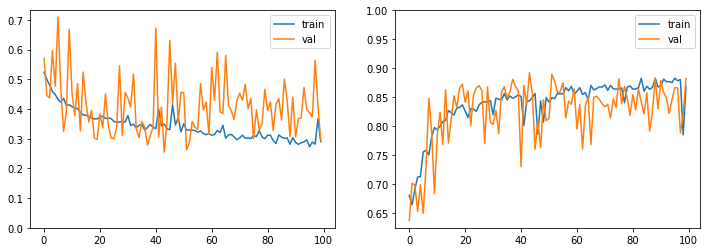

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6293 - accuracy: 0.5341 - precision: 0.9085 - recall: 0.4614 - f1: 0.5964 - specificity: 0.7959 - negative_predictive_value: 0.2624 - matthews_correlation_coefficient: 0.2174 - val_loss: 0.5726 - val_accuracy: 0.5672 - val_precision: 0.8999 - val_recall: 0.5276 - val_f1: 0.6588 - val_specificity: 0.7708 - val_negative_predictive_value: 0.2841 - val_matthews_correlation_coefficient: 0.2334

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23345, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_22-00_56_53.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6290 - accuracy: 0.5390 - precision: 0.9171 - recall: 0.4685 - f1: 0.6084 - specificity: 0.8128 - negative_predictive_value: 0.2788 - matthews_correlation_coefficient: 0.2323 - val_loss: 0.6883 - val_accuracy: 0.4770 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient improved from 0.32703 to 0.34244, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_22-00_56_53.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5752 - accuracy: 0.6419 - precision: 0.9240 - recall: 0.6027 - f1: 0.7215 - specificity: 0.7996 - negative_predictive_value: 0.3454 - matthews_correlation_coefficient: 0.3266 - val_loss: 0.5552 - val_accuracy: 0.6574 - val_precision: 0.9334 - val_recall: 0.6254 - val_f1: 0.7437 - val_specificity: 0.8109 - val_negative_predictive_value: 0.3481 - val_matthews_correlation_coefficient: 0.3493

Epoch 00015: val_matthews_correlation_coefficient improved from 0.34244 to 0.34928, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_22-00_56_53.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5730 - accuracy: 0.6575 - precision: 0.9246 - recall: 0.6281 - f1: 0.7403 - specificity: 0.7981 - negati

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5410 - accuracy: 0.6918 - precision: 0.9268 - recall: 0.6694 - f1: 0.7711 - specificity: 0.8002 - negative_predictive_value: 0.3796 - matthews_correlation_coefficient: 0.3753 - val_loss: 0.4965 - val_accuracy: 0.7233 - val_precision: 0.9170 - val_recall: 0.7259 - val_f1: 0.8074 - val_specificity: 0.7312 - val_negative_predictive_value: 0.3988 - val_matthews_correlation_coefficient: 0.3786

Epoch 00029: val_matthews_correlation_coefficient improved from 0.36789 to 0.37857, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_22-00_56_53.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5386 - accuracy: 0.6957 - precision: 0.9212 - recall: 0.6675 - f1: 0.7676 - specificity: 0.7896 - negative_predictive_value: 0.3873 - matthews_correlation_coefficient: 0.3783 - val_loss: 0.5975 - val_accuracy: 0.6583 - val_precision: 0.9331 - val_recall: 0.6250 - val_f1: 0.7438 - val_spec


Epoch 00043: val_matthews_correlation_coefficient improved from 0.37857 to 0.38104, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_22-00_56_53.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5197 - accuracy: 0.7015 - precision: 0.9287 - recall: 0.6777 - f1: 0.7773 - specificity: 0.7903 - negative_predictive_value: 0.3944 - matthews_correlation_coefficient: 0.3872 - val_loss: 0.6268 - val_accuracy: 0.6340 - val_precision: 0.9509 - val_recall: 0.5809 - val_f1: 0.7138 - val_specificity: 0.8658 - val_negative_predictive_value: 0.3400 - val_matthews_correlation_coefficient: 0.3589

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38104
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5192 - accuracy: 0.7041 - precision: 0.9226 - recall: 0.6799 - f1: 0.7766 - specificity: 0.7871 - negative_predictive_value: 0.3950 - matthews_correlation_coefficient: 0.3892 - val_loss: 0.5357 - 


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41543
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5396 - accuracy: 0.6876 - precision: 0.9301 - recall: 0.6570 - f1: 0.7627 - specificity: 0.8011 - negative_predictive_value: 0.3831 - matthews_correlation_coefficient: 0.3769 - val_loss: 0.4909 - val_accuracy: 0.7147 - val_precision: 0.9233 - val_recall: 0.7057 - val_f1: 0.7971 - val_specificity: 0.7659 - val_negative_predictive_value: 0.3921 - val_matthews_correlation_coefficient: 0.3844

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41543
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5132 - accuracy: 0.7106 - precision: 0.9263 - recall: 0.6962 - f1: 0.7864 - specificity: 0.7770 - negative_predictive_value: 0.4131 - matthews_correlation_coefficient: 0.3963 - val_loss: 0.5285 - val_accuracy: 0.6982 - val_precision: 0.9337 - val_recall: 0.6767 - val_f1: 0.7807 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.41543
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4940 - accuracy: 0.7304 - precision: 0.9332 - recall: 0.7112 - f1: 0.8008 - specificity: 0.7792 - negative_predictive_value: 0.4153 - matthews_correlation_coefficient: 0.4101 - val_loss: 0.5007 - val_accuracy: 0.7016 - val_precision: 0.9303 - val_recall: 0.6839 - val_f1: 0.7844 - val_specificity: 0.7930 - val_negative_predictive_value: 0.3834 - val_matthews_correlation_coefficient: 0.3854

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.41543
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4925 - accuracy: 0.7167 - precision: 0.9265 - recall: 0.6901 - f1: 0.7859 - specificity: 0.8043 - negative_predictive_value: 0.4052 - matthews_correlation_coefficient: 0.4073 - val_loss: 0.5346 - val_accuracy: 0.6878 - val_precision: 0.9402 - val_recall: 0.6575 - val_f1: 0.7691 - val_spe

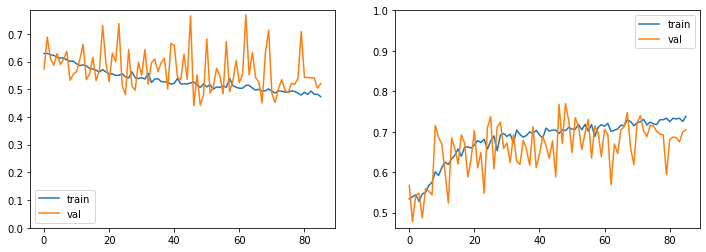

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5013 - accuracy: 0.7456 - precision: 0.8197 - recall: 0.7650 - f1: 0.7772 - specificity: 0.7340 - negative_predictive_value: 0.6888 - matthews_correlation_coefficient: 0.5027 - val_loss: 0.4238 - val_accuracy: 0.7979 - val_precision: 0.8686 - val_recall: 0.7391 - val_f1: 0.7935 - val_specificity: 0.8353 - val_negative_predictive_value: 0.6798 - val_matthews_correlation_coefficient: 0.5875

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.58749, saving model to ../models/autoencoders_requirements/varied_background_2020_03_22-01_09_40.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4195 - accuracy: 0.7852 - precision: 0.8448 - recall: 0.8089 - f1: 0.8168 - specificity: 0.7641 - negative_predictive_value: 0.7293 - matthews_correlation_coefficient: 0.5725 - val_loss: 0.4196 - val_accuracy: 0.7780 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3555 - accuracy: 0.8243 - precision: 0.8779 - recall: 0.8421 - f1: 0.8502 - specificity: 0.8148 - negative_predictive_value: 0.7807 - matthews_correlation_coefficient: 0.6564 - val_loss: 0.3150 - val_accuracy: 0.8673 - val_precision: 0.8913 - val_recall: 0.8362 - val_f1: 0.8602 - val_specificity: 0.8842 - val_negative_predictive_value: 0.8060 - val_matthews_correlation_coefficient: 0.7082

Epoch 00015: val_matthews_correlation_coefficient improved from 0.69538 to 0.70824, saving model to ../models/autoencoders_requirements/varied_background_2020_03_22-01_09_40.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3380 - accuracy: 0.8343 - precision: 0.8874 - recall: 0.8461 - f1: 0.8599 - specificity: 0.8313 - negative_predictive_value: 0.7777 - matthews_correlation_coefficient: 0.6705 - val_loss: 0.3278 - val_accuracy: 0.8500 - val_precision: 0.9088 - val_recall: 0.7866 - val_f1: 0.8396 - va

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3340 - accuracy: 0.8397 - precision: 0.8806 - recall: 0.8497 - f1: 0.8587 - specificity: 0.8238 - negative_predictive_value: 0.7876 - matthews_correlation_coefficient: 0.6768 - val_loss: 0.2900 - val_accuracy: 0.8760 - val_precision: 0.8763 - val_recall: 0.8713 - val_f1: 0.8717 - val_specificity: 0.8254 - val_negative_predictive_value: 0.8150 - val_matthews_correlation_coefficient: 0.7205

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.73640
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3078 - accuracy: 0.8599 - precision: 0.8955 - recall: 0.8756 - f1: 0.8817 - specificity: 0.8417 - negative_predictive_value: 0.8174 - matthews_correlation_coefficient: 0.7145 - val_loss: 0.3001 - val_accuracy: 0.8742 - val_precision: 0.8866 - val_recall: 0.8541 - val_f1: 0.8682 - val_specificity: 0.8480 - val_negative_predictive_value: 0.7971 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2882 - accuracy: 0.8705 - precision: 0.8985 - recall: 0.8771 - f1: 0.8838 - specificity: 0.8597 - negative_predictive_value: 0.8213 - matthews_correlation_coefficient: 0.7294 - val_loss: 0.3113 - val_accuracy: 0.8569 - val_precision: 0.9104 - val_recall: 0.7938 - val_f1: 0.8454 - val_specificity: 0.9192 - val_negative_predictive_value: 0.7742 - val_matthews_correlation_coefficient: 0.6982

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.73640
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2947 - accuracy: 0.8560 - precision: 0.9013 - recall: 0.8651 - f1: 0.8777 - specificity: 0.8501 - negative_predictive_value: 0.8039 - matthews_correlation_coefficient: 0.7095 - val_loss: 0.2791 - val_accuracy: 0.8777 - val_precision: 0.8874 - val_recall: 0.8609 - val_f1: 0.8718 - val_specificity: 0.8416 - val_negative_predictive_value: 0.8057 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2870 - accuracy: 0.8672 - precision: 0.9066 - recall: 0.8792 - f1: 0.8878 - specificity: 0.8480 - negative_predictive_value: 0.8190 - matthews_correlation_coefficient: 0.7253 - val_loss: 0.2680 - val_accuracy: 0.8899 - val_precision: 0.8762 - val_recall: 0.8956 - val_f1: 0.8839 - val_specificity: 0.8465 - val_negative_predictive_value: 0.8707 - val_matthews_correlation_coefficient: 0.7440

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.74945
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2765 - accuracy: 0.8685 - precision: 0.9069 - recall: 0.8804 - f1: 0.8894 - specificity: 0.8540 - negative_predictive_value: 0.8147 - matthews_correlation_coefficient: 0.7272 - val_loss: 0.2580 - val_accuracy: 0.8942 - val_precision: 0.8470 - val_recall: 0.9453 - val_f1: 0.8914 - val_specificity: 0.7541 - val_negative_predictive_value: 0.9192 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.76358
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2612 - accuracy: 0.8813 - precision: 0.9089 - recall: 0.8986 - f1: 0.8998 - specificity: 0.8571 - negative_predictive_value: 0.8405 - matthews_correlation_coefficient: 0.7519 - val_loss: 0.2677 - val_accuracy: 0.8916 - val_precision: 0.8596 - val_recall: 0.9221 - val_f1: 0.8877 - val_specificity: 0.7813 - val_negative_predictive_value: 0.8867 - val_matthews_correlation_coefficient: 0.7508

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.76358
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2553 - accuracy: 0.8844 - precision: 0.9162 - recall: 0.8947 - f1: 0.9024 - specificity: 0.8660 - negative_predictive_value: 0.8384 - matthews_correlation_coefficient: 0.7569 - val_loss: 0.2768 - val_accuracy: 0.8873 - val_precision: 0.8771 - val_recall: 0.8902 - val_f1: 0.8812 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2608 - accuracy: 0.8809 - precision: 0.9112 - recall: 0.8963 - f1: 0.8998 - specificity: 0.8610 - negative_predictive_value: 0.8432 - matthews_correlation_coefficient: 0.7551 - val_loss: 0.2514 - val_accuracy: 0.8994 - val_precision: 0.8655 - val_recall: 0.9279 - val_f1: 0.8934 - val_specificity: 0.7920 - val_negative_predictive_value: 0.9002 - val_matthews_correlation_coefficient: 0.7687

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.78458
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2590 - accuracy: 0.8839 - precision: 0.9120 - recall: 0.8984 - f1: 0.9010 - specificity: 0.8676 - negative_predictive_value: 0.8325 - matthews_correlation_coefficient: 0.7562 - val_loss: 0.2482 - val_accuracy: 0.8994 - val_precision: 0.8568 - val_recall: 0.9394 - val_f1: 0.8946 - val_specificity: 0.7754 - val_negative_predictive_value: 0.9140 - val_matthews_correlation_coefficie

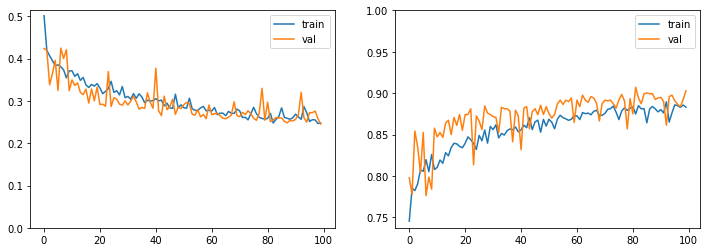

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5770 - accuracy: 0.6983 - precision: 0.9275 - recall: 0.6735 - f1: 0.7731 - specificity: 0.7936 - negative_predictive_value: 0.3996 - matthews_correlation_coefficient: 0.3866 - val_loss: 0.6409 - val_accuracy: 0.6921 - val_precision: 0.9524 - val_recall: 0.6552 - val_f1: 0.7716 - val_specificity: 0.8483 - val_negative_predictive_value: 0.3865 - val_matthews_correlation_coefficient: 0.4111

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.41112, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_22-01_24_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5607 - accuracy: 0.7039 - precision: 0.9379 - recall: 0.6716 - f1: 0.7791 - specificity: 0.8197 - negative_predictive_value: 0.3944 - matthews_correlation_coefficient: 0.4015 - val_loss: 0.5251 - val_accuracy: 0.6973 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5470 - accuracy: 0.6987 - precision: 0.9381 - recall: 0.6644 - f1: 0.7748 - specificity: 0.8317 - negative_predictive_value: 0.3900 - matthews_correlation_coefficient: 0.4010 - val_loss: 0.5619 - val_accuracy: 0.6947 - val_precision: 0.9443 - val_recall: 0.6653 - val_f1: 0.7757 - val_specificity: 0.8283 - val_negative_predictive_value: 0.3892 - val_matthews_correlation_coefficient: 0.4037

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41112
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5415 - accuracy: 0.7085 - precision: 0.9373 - recall: 0.6745 - f1: 0.7813 - specificity: 0.8311 - negative_predictive_value: 0.4011 - matthews_correlation_coefficient: 0.4118 - val_loss: 0.5636 - val_accuracy: 0.6930 - val_precision: 0.9484 - val_recall: 0.6600 - val_f1: 0.7734 - val_specificity: 0.8374 - val_negative_predictive_value: 0.3882 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42319
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5342 - accuracy: 0.7072 - precision: 0.9335 - recall: 0.6694 - f1: 0.7765 - specificity: 0.8346 - negative_predictive_value: 0.4064 - matthews_correlation_coefficient: 0.4114 - val_loss: 0.5557 - val_accuracy: 0.6973 - val_precision: 0.9388 - val_recall: 0.6718 - val_f1: 0.7795 - val_specificity: 0.8083 - val_negative_predictive_value: 0.3853 - val_matthews_correlation_coefficient: 0.3927

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42319
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5329 - accuracy: 0.7074 - precision: 0.9429 - recall: 0.6739 - f1: 0.7823 - specificity: 0.8369 - negative_predictive_value: 0.4015 - matthews_correlation_coefficient: 0.4163 - val_loss: 0.5232 - val_accuracy: 0.7008 - val_precision: 0.9435 - val_recall: 0.6734 - val_f1: 0.7813 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42319
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5214 - accuracy: 0.7108 - precision: 0.9439 - recall: 0.6779 - f1: 0.7857 - specificity: 0.8466 - negative_predictive_value: 0.4066 - matthews_correlation_coefficient: 0.4253 - val_loss: 0.4865 - val_accuracy: 0.7190 - val_precision: 0.9242 - val_recall: 0.7145 - val_f1: 0.8018 - val_specificity: 0.7525 - val_negative_predictive_value: 0.4072 - val_matthews_correlation_coefficient: 0.3911

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.42319
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5215 - accuracy: 0.7176 - precision: 0.9430 - recall: 0.6830 - f1: 0.7893 - specificity: 0.8414 - negative_predictive_value: 0.4080 - matthews_correlation_coefficient: 0.4266 - val_loss: 0.5315 - val_accuracy: 0.7060 - val_precision: 0.9429 - val_recall: 0.6809 - val_f1: 0.7864 - val_spe

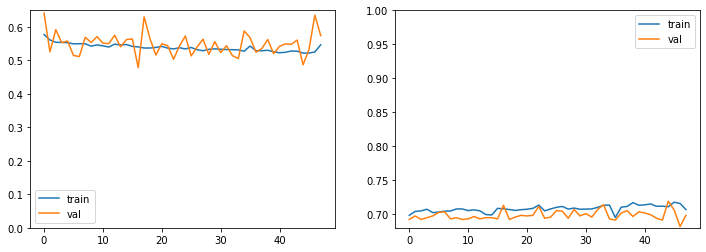

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6069 - accuracy: 0.6881 - precision: 0.7758 - recall: 0.7125 - f1: 0.7183 - specificity: 0.6517 - negative_predictive_value: 0.6044 - matthews_correlation_coefficient: 0.3711 - val_loss: 0.5506 - val_accuracy: 0.7598 - val_precision: 0.7920 - val_recall: 0.7785 - val_f1: 0.7798 - val_specificity: 0.6794 - val_negative_predictive_value: 0.6672 - val_matthews_correlation_coefficient: 0.4848

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.48477, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_22-01_31_36.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5455 - accuracy: 0.7575 - precision: 0.8039 - recall: 0.8093 - f1: 0.7989 - specificity: 0.6797 - negative_predictive_value: 0.6907 - matthews_correlation_coefficient: 0.4924 - val_loss: 0.5255 - val_accuracy: 0.7580 - v


Epoch 00014: val_matthews_correlation_coefficient improved from 0.61165 to 0.62261, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_22-01_31_36.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4304 - accuracy: 0.8184 - precision: 0.8432 - recall: 0.8716 - f1: 0.8517 - specificity: 0.7271 - negative_predictive_value: 0.7789 - matthews_correlation_coefficient: 0.6108 - val_loss: 0.4211 - val_accuracy: 0.8231 - val_precision: 0.8179 - val_recall: 0.8614 - val_f1: 0.8360 - val_specificity: 0.7017 - val_negative_predictive_value: 0.7755 - val_matthews_correlation_coefficient: 0.6040

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.62261
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4311 - accuracy: 0.8245 - precision: 0.8500 - recall: 0.8720 - f1: 0.8556 - specificity: 0.7443 - negative_predictive_value: 0.7793 - matthews_correlation_coefficient: 0.6235 - val_lo

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4128 - accuracy: 0.8299 - precision: 0.8490 - recall: 0.8725 - f1: 0.8562 - specificity: 0.7517 - negative_predictive_value: 0.7834 - matthews_correlation_coefficient: 0.6273 - val_loss: 0.4865 - val_accuracy: 0.7849 - val_precision: 0.8610 - val_recall: 0.7355 - val_f1: 0.7890 - val_specificity: 0.8141 - val_negative_predictive_value: 0.6581 - val_matthews_correlation_coefficient: 0.5606

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.62326
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4086 - accuracy: 0.8286 - precision: 0.8577 - recall: 0.8708 - f1: 0.8594 - specificity: 0.7551 - negative_predictive_value: 0.7836 - matthews_correlation_coefficient: 0.6342 - val_loss: 0.4015 - val_accuracy: 0.8265 - val_precision: 0.8028 - val_recall: 0.8929 - val_f1: 0.8427 - val_specificity: 0.6624 - val_negative_predictive_value: 0.8089 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.63069
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3875 - accuracy: 0.8321 - precision: 0.8654 - recall: 0.8570 - f1: 0.8557 - specificity: 0.7823 - negative_predictive_value: 0.7848 - matthews_correlation_coefficient: 0.6456 - val_loss: 0.4034 - val_accuracy: 0.8248 - val_precision: 0.8552 - val_recall: 0.8155 - val_f1: 0.8314 - val_specificity: 0.7821 - val_negative_predictive_value: 0.7311 - val_matthews_correlation_coefficient: 0.6184

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.63069
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4031 - accuracy: 0.8269 - precision: 0.8649 - recall: 0.8566 - f1: 0.8543 - specificity: 0.7760 - negative_predictive_value: 0.7684 - matthews_correlation_coefficient: 0.6340 - val_loss: 0.3739 - val_accuracy: 0.8387 - val_precision: 0.8223 - val_recall: 0.8866 - val_f1: 0.8499 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3766 - accuracy: 0.8388 - precision: 0.8800 - recall: 0.8635 - f1: 0.8678 - specificity: 0.7936 - negative_predictive_value: 0.7734 - matthews_correlation_coefficient: 0.6545 - val_loss: 0.3887 - val_accuracy: 0.8335 - val_precision: 0.8082 - val_recall: 0.8975 - val_f1: 0.8474 - val_specificity: 0.6736 - val_negative_predictive_value: 0.8252 - val_matthews_correlation_coefficient: 0.6272

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.64129
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3841 - accuracy: 0.8364 - precision: 0.8702 - recall: 0.8561 - f1: 0.8581 - specificity: 0.7927 - negative_predictive_value: 0.7828 - matthews_correlation_coefficient: 0.6514 - val_loss: 0.4084 - val_accuracy: 0.8135 - val_precision: 0.8213 - val_recall: 0.8380 - val_f1: 0.8257 - val_specificity: 0.7237 - val_negative_predictive_value: 0.7517 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3651 - accuracy: 0.8486 - precision: 0.8805 - recall: 0.8640 - f1: 0.8690 - specificity: 0.8100 - negative_predictive_value: 0.7888 - matthews_correlation_coefficient: 0.6777 - val_loss: 0.3997 - val_accuracy: 0.8309 - val_precision: 0.8196 - val_recall: 0.8726 - val_f1: 0.8428 - val_specificity: 0.7044 - val_negative_predictive_value: 0.7917 - val_matthews_correlation_coefficient: 0.6197

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.64129
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3887 - accuracy: 0.8384 - precision: 0.8874 - recall: 0.8459 - f1: 0.8582 - specificity: 0.8176 - negative_predictive_value: 0.7759 - matthews_correlation_coefficient: 0.6642 - val_loss: 0.3661 - val_accuracy: 0.8439 - val_precision: 0.8270 - val_recall: 0.8877 - val_f1: 0.8533 - val_specificity: 0.7196 - val_negative_predictive_value: 0.8140 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.65008
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3516 - accuracy: 0.8527 - precision: 0.8874 - recall: 0.8770 - f1: 0.8787 - specificity: 0.8179 - negative_predictive_value: 0.8022 - matthews_correlation_coefficient: 0.6916 - val_loss: 0.3986 - val_accuracy: 0.8239 - val_precision: 0.8420 - val_recall: 0.8291 - val_f1: 0.8322 - val_specificity: 0.7624 - val_negative_predictive_value: 0.7435 - val_matthews_correlation_coefficient: 0.6149

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.65008
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3472 - accuracy: 0.8527 - precision: 0.8851 - recall: 0.8644 - f1: 0.8701 - specificity: 0.8270 - negative_predictive_value: 0.8050 - matthews_correlation_coefficient: 0.6896 - val_loss: 0.4095 - val_accuracy: 0.8222 - val_precision: 0.8328 - val_recall: 0.8385 - val_f1: 0.8321 - val_spe

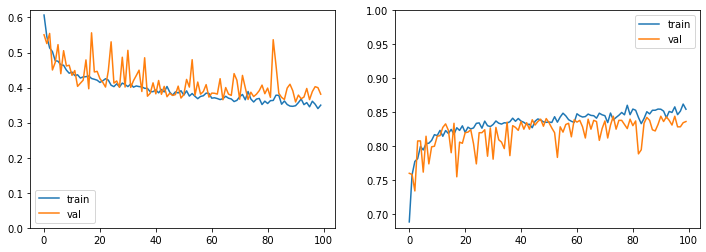

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 60s 13ms/step - loss: 0.6393 - accuracy: 0.5447 - precision: 0.8924 - recall: 0.4816 - f1: 0.6060 - specificity: 0.7588 - negative_predictive_value: 0.2667 - matthews_correlation_coefficient: 0.2076 - val_loss: 0.6246 - val_accuracy: 0.5126 - val_precision: 0.9437 - val_recall: 0.4275 - val_f1: 0.5752 - val_specificity: 0.8791 - val_negative_predictive_value: 0.2855 - val_matthews_correlation_coefficient: 0.2635

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26355, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_22-01_46_23.h5
Epoch 2/100
4610/4610 [==============================] - 54s 12ms/step - loss: 0.6236 - accuracy: 0.5597 - precision: 0.9086 - recall: 0.4962 - f1: 0.6283 - specificity: 0.7936 - negative_predictive_value: 0.2961 - matthews_correlation_coefficient: 0.2410 - val_loss: 0.6351 - val_accuracy: 0.5013 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5706 - accuracy: 0.6473 - precision: 0.9130 - recall: 0.6067 - f1: 0.7200 - specificity: 0.7845 - negative_predictive_value: 0.3536 - matthews_correlation_coefficient: 0.3274 - val_loss: 0.6539 - val_accuracy: 0.5854 - val_precision: 0.9207 - val_recall: 0.5362 - val_f1: 0.6690 - val_specificity: 0.8007 - val_negative_predictive_value: 0.3104 - val_matthews_correlation_coefficient: 0.2775

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35506
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5668 - accuracy: 0.6696 - precision: 0.9167 - recall: 0.6350 - f1: 0.7420 - specificity: 0.7858 - negative_predictive_value: 0.3723 - matthews_correlation_coefficient: 0.3515 - val_loss: 0.6210 - val_accuracy: 0.6097 - val_precision: 0.9520 - val_recall: 0.5488 - val_f1: 0.6903 - val_specificity: 0.8689 - val_negative_predictive_value: 0.3306 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5426 - accuracy: 0.6826 - precision: 0.9251 - recall: 0.6502 - f1: 0.7570 - specificity: 0.8009 - negative_predictive_value: 0.3826 - matthews_correlation_coefficient: 0.3705 - val_loss: 0.5586 - val_accuracy: 0.6826 - val_precision: 0.9386 - val_recall: 0.6533 - val_f1: 0.7657 - val_specificity: 0.8166 - val_negative_predictive_value: 0.3749 - val_matthews_correlation_coefficient: 0.3818

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40811
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5318 - accuracy: 0.6959 - precision: 0.9264 - recall: 0.6700 - f1: 0.7708 - specificity: 0.7870 - negative_predictive_value: 0.3965 - matthews_correlation_coefficient: 0.3825 - val_loss: 0.4606 - val_accuracy: 0.7641 - val_precision: 0.9093 - val_recall: 0.7908 - val_f1: 0.8420 - val_specificity: 0.6841 - val_negative_predictive_value: 0.4544 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42016
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5358 - accuracy: 0.6952 - precision: 0.9238 - recall: 0.6765 - f1: 0.7718 - specificity: 0.7821 - negative_predictive_value: 0.4047 - matthews_correlation_coefficient: 0.3847 - val_loss: 0.4964 - val_accuracy: 0.7485 - val_precision: 0.9084 - val_recall: 0.7706 - val_f1: 0.8296 - val_specificity: 0.6907 - val_negative_predictive_value: 0.4362 - val_matthews_correlation_coefficient: 0.3956

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42016
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5318 - accuracy: 0.6892 - precision: 0.9260 - recall: 0.6654 - f1: 0.7665 - specificity: 0.7858 - negative_predictive_value: 0.3903 - matthews_correlation_coefficient: 0.3740 - val_loss: 0.4628 - val_accuracy: 0.7719 - val_precision: 0.9150 - val_recall: 0.7955 - val_f1: 0.8472 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5009 - accuracy: 0.7217 - precision: 0.9259 - recall: 0.7090 - f1: 0.7965 - specificity: 0.7916 - negative_predictive_value: 0.4279 - matthews_correlation_coefficient: 0.4168 - val_loss: 0.7216 - val_accuracy: 0.6045 - val_precision: 0.9504 - val_recall: 0.5428 - val_f1: 0.6831 - val_specificity: 0.8730 - val_negative_predictive_value: 0.3310 - val_matthews_correlation_coefficient: 0.3402

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43805
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5102 - accuracy: 0.7130 - precision: 0.9225 - recall: 0.6885 - f1: 0.7801 - specificity: 0.7932 - negative_predictive_value: 0.4170 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.6553 - val_accuracy: 0.6262 - val_precision: 0.9498 - val_recall: 0.5711 - val_f1: 0.7068 - val_specificity: 0.8665 - val_negative_predictive_value: 0.3414 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.44887
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4946 - accuracy: 0.7382 - precision: 0.9314 - recall: 0.7241 - f1: 0.8071 - specificity: 0.7916 - negative_predictive_value: 0.4489 - matthews_correlation_coefficient: 0.4398 - val_loss: 0.5536 - val_accuracy: 0.6808 - val_precision: 0.9495 - val_recall: 0.6429 - val_f1: 0.7610 - val_specificity: 0.8508 - val_negative_predictive_value: 0.3805 - val_matthews_correlation_coefficient: 0.4015

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.44887
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4813 - accuracy: 0.7412 - precision: 0.9289 - recall: 0.7302 - f1: 0.8124 - specificity: 0.7797 - negative_predictive_value: 0.4385 - matthews_correlation_coefficient: 0.4292 - val_loss: 0.5234 - val_accuracy: 0.7077 - val_precision: 0.9443 - val_recall: 0.6809 - val_f1: 0.7866 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.46470
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4912 - accuracy: 0.7338 - precision: 0.9362 - recall: 0.7173 - f1: 0.8053 - specificity: 0.8049 - negative_predictive_value: 0.4341 - matthews_correlation_coefficient: 0.4352 - val_loss: 0.4106 - val_accuracy: 0.8144 - val_precision: 0.9125 - val_recall: 0.8548 - val_f1: 0.8798 - val_specificity: 0.6746 - val_negative_predictive_value: 0.5420 - val_matthews_correlation_coefficient: 0.4876

Epoch 00088: val_matthews_correlation_coefficient improved from 0.46470 to 0.48761, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_22-01_46_23.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4746 - accuracy: 0.7497 - precision: 0.9343 - recall: 0.7375 - f1: 0.8181 - specificity: 0.7877 - negative_predictive_value: 0.4502 - matthews_correlation_coefficient: 0.4445 - val_loss: 0.6590 - val

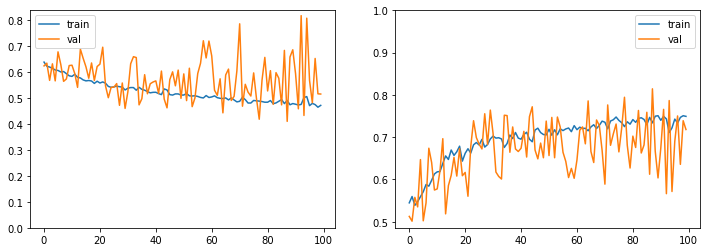

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5054 - accuracy: 0.7310 - precision: 0.8656 - recall: 0.7268 - f1: 0.7799 - specificity: 0.7562 - negative_predictive_value: 0.5789 - matthews_correlation_coefficient: 0.4614 - val_loss: 0.4804 - val_accuracy: 0.7528 - val_precision: 0.8291 - val_recall: 0.7431 - val_f1: 0.7808 - val_specificity: 0.7127 - val_negative_predictive_value: 0.5860 - val_matthews_correlation_coefficient: 0.4609

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.46091, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_22-02_05_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4675 - accuracy: 0.7547 - precision: 0.8966 - recall: 0.7244 - f1: 0.7955 - specificity: 0.8257 - negative_predictive_value: 0.5929 - matthews_correlation_coefficient: 0.5174 - val_loss: 0.5448 - val_accuracy: 0.7034 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4309 - accuracy: 0.7792 - precision: 0.9018 - recall: 0.7544 - f1: 0.8167 - specificity: 0.8341 - negative_predictive_value: 0.6226 - matthews_correlation_coefficient: 0.5553 - val_loss: 0.4225 - val_accuracy: 0.7918 - val_precision: 0.8666 - val_recall: 0.7623 - val_f1: 0.8088 - val_specificity: 0.7935 - val_negative_predictive_value: 0.6304 - val_matthews_correlation_coefficient: 0.5512

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55735
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4228 - accuracy: 0.7887 - precision: 0.9077 - recall: 0.7670 - f1: 0.8275 - specificity: 0.8300 - negative_predictive_value: 0.6322 - matthews_correlation_coefficient: 0.5666 - val_loss: 0.4481 - val_accuracy: 0.7719 - val_precision: 0.8850 - val_recall: 0.7109 - val_f1: 0.7850 - val_specificity: 0.8339 - val_negative_predictive_value: 0.5946 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3995 - accuracy: 0.8052 - precision: 0.9142 - recall: 0.7861 - f1: 0.8406 - specificity: 0.8426 - negative_predictive_value: 0.6633 - matthews_correlation_coefficient: 0.6013 - val_loss: 0.4088 - val_accuracy: 0.8101 - val_precision: 0.8153 - val_recall: 0.8602 - val_f1: 0.8355 - val_specificity: 0.6411 - val_negative_predictive_value: 0.7262 - val_matthews_correlation_coefficient: 0.5456

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57652
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3937 - accuracy: 0.8137 - precision: 0.9196 - recall: 0.7954 - f1: 0.8481 - specificity: 0.8504 - negative_predictive_value: 0.6749 - matthews_correlation_coefficient: 0.6184 - val_loss: 0.4088 - val_accuracy: 0.7971 - val_precision: 0.7899 - val_recall: 0.8848 - val_f1: 0.8319 - val_specificity: 0.5622 - val_negative_predictive_value: 0.7403 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3956 - accuracy: 0.8048 - precision: 0.9162 - recall: 0.7847 - f1: 0.8399 - specificity: 0.8531 - negative_predictive_value: 0.6564 - matthews_correlation_coefficient: 0.6046 - val_loss: 0.4172 - val_accuracy: 0.7944 - val_precision: 0.8945 - val_recall: 0.7396 - val_f1: 0.8060 - val_specificity: 0.8452 - val_negative_predictive_value: 0.6233 - val_matthews_correlation_coefficient: 0.5759

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64184
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3881 - accuracy: 0.8152 - precision: 0.9172 - recall: 0.7961 - f1: 0.8477 - specificity: 0.8567 - negative_predictive_value: 0.6730 - matthews_correlation_coefficient: 0.6212 - val_loss: 0.3819 - val_accuracy: 0.8231 - val_precision: 0.8405 - val_recall: 0.8484 - val_f1: 0.8425 - val_specificity: 0.7068 - val_negative_predictive_value: 0.7154 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3638 - accuracy: 0.8252 - precision: 0.9276 - recall: 0.8065 - f1: 0.8588 - specificity: 0.8681 - negative_predictive_value: 0.6909 - matthews_correlation_coefficient: 0.6447 - val_loss: 0.3911 - val_accuracy: 0.8066 - val_precision: 0.8271 - val_recall: 0.8432 - val_f1: 0.8319 - val_specificity: 0.6801 - val_negative_predictive_value: 0.6988 - val_matthews_correlation_coefficient: 0.5497

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.64184
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3687 - accuracy: 0.8275 - precision: 0.9229 - recall: 0.8155 - f1: 0.8616 - specificity: 0.8584 - negative_predictive_value: 0.6944 - matthews_correlation_coefficient: 0.6438 - val_loss: 0.4060 - val_accuracy: 0.7910 - val_precision: 0.8630 - val_recall: 0.7708 - val_f1: 0.8104 - val_specificity: 0.7724 - val_negative_predictive_value: 0.6344 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.64184
Epoch 00072: early stopping

   Final Accuracy:  84.22%
  Final Precision:  90.16%
     Final Recall:  85.71%
  Final F-measure:  87.88%
Final Specificity:  81.20%
        Final NPV:  73.87%
        Final MCC:  65.46%
[[311  72]
 [110 660]]
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       383
           1       0.90      0.86      0.88       770

    accuracy                           0.84      1153
   macro avg       0.82      0.83      0.83      1153
weighted avg       0.85      0.84      0.84      1153



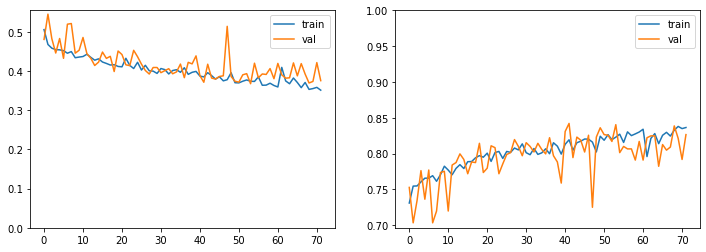

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6420 - accuracy: 0.6148 - precision: 0.8357 - recall: 0.6028 - f1: 0.6859 - specificity: 0.6404 - negative_predictive_value: 0.3531 - matthews_correlation_coefficient: 0.2198 - val_loss: 0.6341 - val_accuracy: 0.6505 - val_precision: 0.8274 - val_recall: 0.6307 - val_f1: 0.7121 - val_specificity: 0.6664 - val_negative_predictive_value: 0.3862 - val_matthews_correlation_coefficient: 0.2507

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25067, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_22-02_16_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6210 - accuracy: 0.6586 - precision: 0.8521 - recall: 0.6555 - f1: 0.7340 - specificity: 0.6555 - negative_predictive_value: 0.3858 - matthews_correlation_coefficient: 0.2773 - val_loss: 0.5866 - val_accuracy: 0.6843 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.42428
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5530 - accuracy: 0.7213 - precision: 0.8927 - recall: 0.7219 - f1: 0.7929 - specificity: 0.7197 - negative_predictive_value: 0.4555 - matthews_correlation_coefficient: 0.3909 - val_loss: 0.5341 - val_accuracy: 0.7589 - val_precision: 0.8743 - val_recall: 0.7468 - val_f1: 0.8030 - val_specificity: 0.7447 - val_negative_predictive_value: 0.5131 - val_matthews_correlation_coefficient: 0.4340

Epoch 00015: val_matthews_correlation_coefficient improved from 0.42428 to 0.43396, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_22-02_16_28.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.7289 - precision: 0.8851 - recall: 0.7299 - f1: 0.7920 - specificity: 0.7124 - negative_predictive_value: 0.4722 - matthews_correlation_coefficient: 0.4015 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5183 - accuracy: 0.7414 - precision: 0.9054 - recall: 0.7395 - f1: 0.8091 - specificity: 0.7430 - negative_predictive_value: 0.4821 - matthews_correlation_coefficient: 0.4304 - val_loss: 0.4511 - val_accuracy: 0.8049 - val_precision: 0.8738 - val_recall: 0.8127 - val_f1: 0.8406 - val_specificity: 0.7157 - val_negative_predictive_value: 0.5853 - val_matthews_correlation_coefficient: 0.4905

Epoch 00029: val_matthews_correlation_coefficient improved from 0.43999 to 0.49049, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_22-02_16_28.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5213 - accuracy: 0.7482 - precision: 0.8997 - recall: 0.7547 - f1: 0.8166 - specificity: 0.7276 - negative_predictive_value: 0.4859 - matthews_correlation_coefficient: 0.4287 - val_loss: 0.4794 - val_accuracy: 0.7884 - val_precision: 0.8670 - val_recall: 0.7978 - val_f1: 0.8294 - 


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.49049
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5024 - accuracy: 0.7390 - precision: 0.9096 - recall: 0.7308 - f1: 0.8041 - specificity: 0.7668 - negative_predictive_value: 0.4816 - matthews_correlation_coefficient: 0.4395 - val_loss: 0.4258 - val_accuracy: 0.8040 - val_precision: 0.8576 - val_recall: 0.8320 - val_f1: 0.8432 - val_specificity: 0.6428 - val_negative_predictive_value: 0.5864 - val_matthews_correlation_coefficient: 0.4571

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49049
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5058 - accuracy: 0.7551 - precision: 0.9042 - recall: 0.7606 - f1: 0.8196 - specificity: 0.7607 - negative_predictive_value: 0.5080 - matthews_correlation_coefficient: 0.4617 - val_loss: 0.5324 - val_accuracy: 0.7450 - val_precision: 0.8806 - val_recall: 0.7212 - val_f1: 0.7899 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.49049
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7638 - precision: 0.9139 - recall: 0.7648 - f1: 0.8275 - specificity: 0.7609 - negative_predictive_value: 0.5165 - matthews_correlation_coefficient: 0.4729 - val_loss: 0.4582 - val_accuracy: 0.7780 - val_precision: 0.8792 - val_recall: 0.7666 - val_f1: 0.8169 - val_specificity: 0.7460 - val_negative_predictive_value: 0.5400 - val_matthews_correlation_coefficient: 0.4615
Restoring model weights from the end of the best epoch

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.49049
Epoch 00059: early stopping

   Final Accuracy:  80.49%
  Final Precision:  89.91%
     Final Recall:  83.64%
  Final F-measure:  86.66%
Final Specificity:  70.61%
        Final NPV:  57.94%
        Final MCC:  50.95%
[[197  82]
 [143 731]]
              precision    recall  f1-score   support

           0     

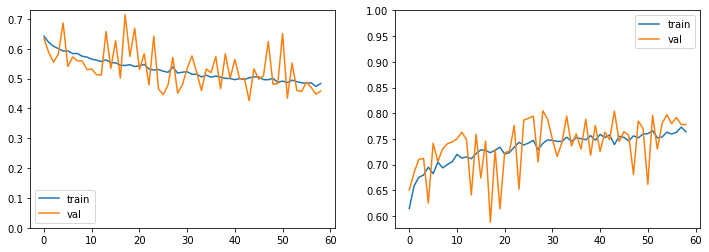

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5795 - accuracy: 0.5317 - precision: 0.9656 - recall: 0.4949 - f1: 0.6481 - specificity: 0.8624 - negative_predictive_value: 0.1794 - matthews_correlation_coefficient: 0.2240 - val_loss: 0.6738 - val_accuracy: 0.4588 - val_precision: 0.9535 - val_recall: 0.3885 - val_f1: 0.5466 - val_specificity: 0.9039 - val_negative_predictive_value: 0.1567 - val_matthews_correlation_coefficient: 0.2071

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20707, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_22-02_25_20.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5580 - accuracy: 0.5555 - precision: 0.9676 - recall: 0.5196 - f1: 0.6648 - specificity: 0.8199 - negative_predictive_value: 0.1916 - matthews_correlation_coefficient: 0.2293 - val_loss: 0.5803 - val_accuracy: 0.4918 - val_pre

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4724 - accuracy: 0.6965 - precision: 0.9706 - recall: 0.6845 - f1: 0.7945 - specificity: 0.7903 - negative_predictive_value: 0.2587 - matthews_correlation_coefficient: 0.3285 - val_loss: 0.6123 - val_accuracy: 0.5785 - val_precision: 0.9483 - val_recall: 0.5255 - val_f1: 0.6690 - val_specificity: 0.8791 - val_negative_predictive_value: 0.2147 - val_matthews_correlation_coefficient: 0.2525

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30967
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4609 - accuracy: 0.7143 - precision: 0.9742 - recall: 0.7027 - f1: 0.8085 - specificity: 0.8332 - negative_predictive_value: 0.2729 - matthews_correlation_coefficient: 0.3552 - val_loss: 0.5426 - val_accuracy: 0.6548 - val_precision: 0.9511 - val_recall: 0.6085 - val_f1: 0.7390 - val_specificity: 0.8946 - val_negative_predictive_value: 0.2507 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4080 - accuracy: 0.7720 - precision: 0.9761 - recall: 0.7666 - f1: 0.8495 - specificity: 0.8158 - negative_predictive_value: 0.3407 - matthews_correlation_coefficient: 0.4169 - val_loss: 0.5295 - val_accuracy: 0.6791 - val_precision: 0.9659 - val_recall: 0.6268 - val_f1: 0.7569 - val_specificity: 0.9458 - val_negative_predictive_value: 0.2701 - val_matthews_correlation_coefficient: 0.3606

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.41030
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3943 - accuracy: 0.7681 - precision: 0.9772 - recall: 0.7570 - f1: 0.8477 - specificity: 0.8369 - negative_predictive_value: 0.3197 - matthews_correlation_coefficient: 0.4119 - val_loss: 0.2601 - val_accuracy: 0.8951 - val_precision: 0.9319 - val_recall: 0.8966 - val_f1: 0.9131 - val_specificity: 0.6879 - val_negative_predictive_value: 0.5330 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3550 - accuracy: 0.7998 - precision: 0.9807 - recall: 0.7894 - f1: 0.8688 - specificity: 0.8395 - negative_predictive_value: 0.3722 - matthews_correlation_coefficient: 0.4620 - val_loss: 0.4248 - val_accuracy: 0.7407 - val_precision: 0.9654 - val_recall: 0.6955 - val_f1: 0.8059 - val_specificity: 0.9299 - val_negative_predictive_value: 0.3119 - val_matthews_correlation_coefficient: 0.4084

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3808 - accuracy: 0.7924 - precision: 0.9823 - recall: 0.7824 - f1: 0.8634 - specificity: 0.8533 - negative_predictive_value: 0.3646 - matthews_correlation_coefficient: 0.4599 - val_loss: 0.4690 - val_accuracy: 0.7320 - val_precision: 0.9660 - val_recall: 0.6852 - val_f1: 0.7984 - val_spe


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3591 - accuracy: 0.7933 - precision: 0.9804 - recall: 0.7860 - f1: 0.8660 - specificity: 0.8310 - negative_predictive_value: 0.3667 - matthews_correlation_coefficient: 0.4553 - val_loss: 0.6459 - val_accuracy: 0.6479 - val_precision: 0.9686 - val_recall: 0.5906 - val_f1: 0.7290 - val_specificity: 0.9518 - val_negative_predictive_value: 0.2560 - val_matthews_correlation_coefficient: 0.3423

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3359 - accuracy: 0.8137 - precision: 0.9820 - recall: 0.8040 - f1: 0.8798 - specificity: 0.8642 - negative_predictive_value: 0.3768 - matthews_correlation_coefficient: 0.4808 - val_loss: 0.5491 - val_accuracy: 0.6930 - val_precision: 0.9704 - val_recall: 0.6389 - val_f1: 0.7672 - val_spe

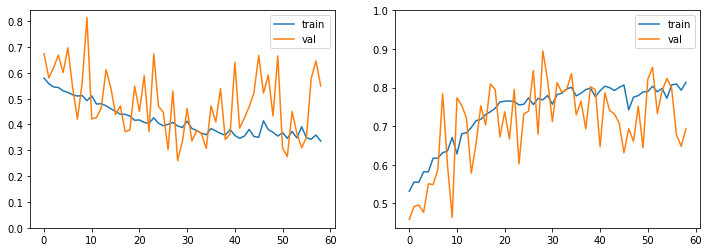

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5746 - accuracy: 0.6584 - precision: 0.9104 - recall: 0.6410 - f1: 0.7448 - specificity: 0.7402 - negative_predictive_value: 0.3429 - matthews_correlation_coefficient: 0.3078 - val_loss: 0.5199 - val_accuracy: 0.7467 - val_precision: 0.8773 - val_recall: 0.8030 - val_f1: 0.8352 - val_specificity: 0.5266 - val_negative_predictive_value: 0.3992 - val_matthews_correlation_coefficient: 0.3029

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30287, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_22-02_34_15.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5684 - accuracy: 0.6792 - precision: 0.9134 - recall: 0.6626 - f1: 0.7584 - specificity: 0.7457 - negative_predictive_value: 0.3720 - matthews_correlation_coefficient: 0.3374 - val_loss: 0.7039 - val_accuracy: 0.5429 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5229 - accuracy: 0.7106 - precision: 0.9190 - recall: 0.7035 - f1: 0.7926 - specificity: 0.7437 - negative_predictive_value: 0.3897 - matthews_correlation_coefficient: 0.3677 - val_loss: 0.5627 - val_accuracy: 0.7112 - val_precision: 0.9039 - val_recall: 0.7270 - val_f1: 0.8008 - val_specificity: 0.6635 - val_negative_predictive_value: 0.3808 - val_matthews_correlation_coefficient: 0.3320

Epoch 00015: val_matthews_correlation_coefficient improved from 0.32701 to 0.33200, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_22-02_34_15.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5173 - accuracy: 0.7226 - precision: 0.9198 - recall: 0.7154 - f1: 0.7989 - specificity: 0.7657 - negative_predictive_value: 0.4096 - matthews_correlation_coefficient: 0.3967 - val_loss: 0.6145 - val_accuracy: 0.6592 - val_precision: 0.9108 - val_recall: 0.6501 - val_f1: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4899 - accuracy: 0.7403 - precision: 0.9266 - recall: 0.7340 - f1: 0.8127 - specificity: 0.7439 - negative_predictive_value: 0.4264 - matthews_correlation_coefficient: 0.4077 - val_loss: 0.4688 - val_accuracy: 0.7493 - val_precision: 0.8945 - val_recall: 0.7864 - val_f1: 0.8340 - val_specificity: 0.6058 - val_negative_predictive_value: 0.4163 - val_matthews_correlation_coefficient: 0.3471

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41840
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4959 - accuracy: 0.7297 - precision: 0.9278 - recall: 0.7189 - f1: 0.8025 - specificity: 0.7549 - negative_predictive_value: 0.4195 - matthews_correlation_coefficient: 0.4029 - val_loss: 0.5579 - val_accuracy: 0.6730 - val_precision: 0.9320 - val_recall: 0.6503 - val_f1: 0.7591 - val_specificity: 0.7765 - val_negative_predictive_value: 0.3633 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42094
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4805 - accuracy: 0.7412 - precision: 0.9293 - recall: 0.7334 - f1: 0.8131 - specificity: 0.7745 - negative_predictive_value: 0.4382 - matthews_correlation_coefficient: 0.4295 - val_loss: 0.6498 - val_accuracy: 0.6141 - val_precision: 0.9558 - val_recall: 0.5579 - val_f1: 0.6951 - val_specificity: 0.8651 - val_negative_predictive_value: 0.3331 - val_matthews_correlation_coefficient: 0.3481

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42094
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4753 - accuracy: 0.7458 - precision: 0.9346 - recall: 0.7386 - f1: 0.8184 - specificity: 0.7835 - negative_predictive_value: 0.4422 - matthews_correlation_coefficient: 0.4390 - val_loss: 0.6736 - val_accuracy: 0.6565 - val_precision: 0.9468 - val_recall: 0.6170 - val_f1: 0.7399 - val_spe


Epoch 00058: val_matthews_correlation_coefficient improved from 0.42094 to 0.42610, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_22-02_34_15.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4561 - accuracy: 0.7588 - precision: 0.9381 - recall: 0.7519 - f1: 0.8277 - specificity: 0.7878 - negative_predictive_value: 0.4737 - matthews_correlation_coefficient: 0.4659 - val_loss: 0.6120 - val_accuracy: 0.6297 - val_precision: 0.9512 - val_recall: 0.5808 - val_f1: 0.7108 - val_specificity: 0.8487 - val_negative_predictive_value: 0.3418 - val_matthews_correlation_coefficient: 0.3533

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42610
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4668 - accuracy: 0.7542 - precision: 0.9288 - recall: 0.7437 - f1: 0.8190 - specificity: 0.7877 - negative_predictive_value: 0.4645 - matthews_correlation_coefficient: 0.4560 - val_


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.42610
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4450 - accuracy: 0.7727 - precision: 0.9367 - recall: 0.7685 - f1: 0.8397 - specificity: 0.7928 - negative_predictive_value: 0.4642 - matthews_correlation_coefficient: 0.4700 - val_loss: 0.5775 - val_accuracy: 0.6739 - val_precision: 0.9458 - val_recall: 0.6414 - val_f1: 0.7567 - val_specificity: 0.8220 - val_negative_predictive_value: 0.3706 - val_matthews_correlation_coefficient: 0.3810

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.42610
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4387 - accuracy: 0.7692 - precision: 0.9378 - recall: 0.7652 - f1: 0.8358 - specificity: 0.7885 - negative_predictive_value: 0.4842 - matthews_correlation_coefficient: 0.4791 - val_loss: 0.5945 - val_accuracy: 0.6704 - val_precision: 0.9446 - val_recall: 0.6377 - val_f1: 0.7549 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.44047
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4373 - accuracy: 0.7690 - precision: 0.9430 - recall: 0.7609 - f1: 0.8361 - specificity: 0.8112 - negative_predictive_value: 0.4760 - matthews_correlation_coefficient: 0.4840 - val_loss: 0.4776 - val_accuracy: 0.7173 - val_precision: 0.9301 - val_recall: 0.7097 - val_f1: 0.8002 - val_specificity: 0.7584 - val_negative_predictive_value: 0.3995 - val_matthews_correlation_coefficient: 0.3912

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.44047
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4387 - accuracy: 0.7753 - precision: 0.9402 - recall: 0.7731 - f1: 0.8425 - specificity: 0.8021 - negative_predictive_value: 0.4837 - matthews_correlation_coefficient: 0.4874 - val_loss: 0.5077 - val_accuracy: 0.7095 - val_precision: 0.9398 - val_recall: 0.6915 - val_f1: 0.7920 - val_spe

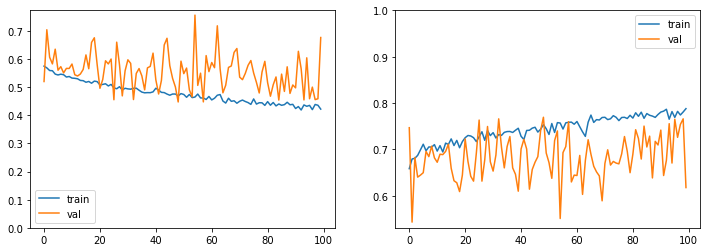

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6293 - accuracy: 0.8100 - precision: 0.9981 - recall: 0.8123 - f1: 0.8815 - specificity: 0.0414 - negative_predictive_value: 0.0036 - matthews_correlation_coefficient: 0.0080 - val_loss: 0.1550 - val_accuracy: 0.9870 - val_precision: 0.9983 - val_recall: 0.9890 - val_f1: 0.9935 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0253

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.02528, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_22-02_49_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.7510 - precision: 0.9984 - recall: 0.7536 - f1: 0.8448 - specificity: 0.0483 - negative_predictive_value: 0.0061 - matthews_correlation_coefficient: 0.0133 - val_loss: 0.1638 - val_accuracy: 0.9324 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2687 - accuracy: 0.8579 - precision: 0.9998 - recall: 0.8585 - f1: 0.9182 - specificity: 0.0759 - negative_predictive_value: 0.0224 - matthews_correlation_coefficient: 0.0347 - val_loss: 0.2167 - val_accuracy: 0.8812 - val_precision: 1.0000 - val_recall: 0.8841 - val_f1: 0.9376 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0293 - val_matthews_correlation_coefficient: 0.0467

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.05318
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1811 - accuracy: 0.9137 - precision: 1.0000 - recall: 0.9140 - f1: 0.9532 - specificity: 0.0966 - negative_predictive_value: 0.0478 - matthews_correlation_coefficient: 0.0620 - val_loss: 0.5590 - val_accuracy: 0.7095 - val_precision: 1.0000 - val_recall: 0.7164 - val_f1: 0.8323 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0095 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2855 - accuracy: 0.8284 - precision: 0.9996 - recall: 0.8294 - f1: 0.9009 - specificity: 0.0759 - negative_predictive_value: 0.0208 - matthews_correlation_coefficient: 0.0329 - val_loss: 0.3067 - val_accuracy: 0.8413 - val_precision: 1.0000 - val_recall: 0.8451 - val_f1: 0.9152 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0176 - val_matthews_correlation_coefficient: 0.0354

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2208 - accuracy: 0.8642 - precision: 0.9998 - recall: 0.8649 - f1: 0.9239 - specificity: 0.0828 - negative_predictive_value: 0.0266 - matthews_correlation_coefficient: 0.0419 - val_loss: 0.0364 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9932 - val_f1: 0.9966 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0540 - accuracy: 0.9740 - precision: 1.0000 - recall: 0.9741 - f1: 0.9865 - specificity: 0.0966 - negative_predictive_value: 0.0672 - matthews_correlation_coefficient: 0.0775 - val_loss: 0.0132 - val_accuracy: 0.9957 - val_precision: 0.9992 - val_recall: 0.9966 - val_f1: 0.9979 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0541 - val_matthews_correlation_coefficient: 0.0541

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1104 - accuracy: 0.9538 - precision: 0.9998 - recall: 0.9542 - f1: 0.9741 - specificity: 0.0828 - negative_predictive_value: 0.0641 - matthews_correlation_coefficient: 0.0693 - val_loss: 0.5452 - val_accuracy: 0.7840 - val_precision: 1.0000 - val_recall: 0.7893 - val_f1: 0.8806 - val_spe

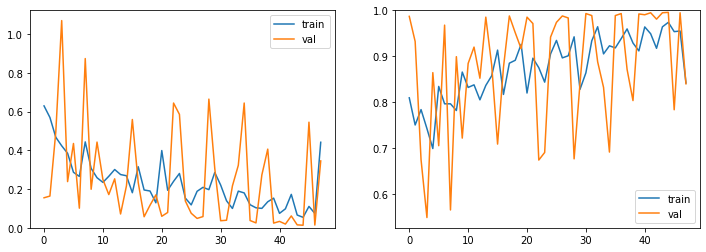

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5967 - accuracy: 0.5607 - precision: 0.9256 - recall: 0.4951 - f1: 0.6312 - specificity: 0.8181 - negative_predictive_value: 0.2867 - matthews_correlation_coefficient: 0.2581 - val_loss: 0.5349 - val_accuracy: 0.6470 - val_precision: 0.9002 - val_recall: 0.6363 - val_f1: 0.7405 - val_specificity: 0.7124 - val_negative_predictive_value: 0.3355 - val_matthews_correlation_coefficient: 0.2853

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28528, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_22-02_56_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5834 - accuracy: 0.5729 - precision: 0.9299 - recall: 0.5097 - f1: 0.6456 - specificity: 0.8200 - negative_predictive_value: 0.3002 - matthews_correlation_coefficient: 0.2737 - val_loss: 0.7442 - val_accuracy: 0.4874 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5340 - accuracy: 0.6564 - precision: 0.9451 - recall: 0.6071 - f1: 0.7304 - specificity: 0.8554 - negative_predictive_value: 0.3625 - matthews_correlation_coefficient: 0.3743 - val_loss: 0.5244 - val_accuracy: 0.6609 - val_precision: 0.9322 - val_recall: 0.6323 - val_f1: 0.7474 - val_specificity: 0.7936 - val_negative_predictive_value: 0.3567 - val_matthews_correlation_coefficient: 0.3492

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38580
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5297 - accuracy: 0.6592 - precision: 0.9403 - recall: 0.6081 - f1: 0.7282 - specificity: 0.8528 - negative_predictive_value: 0.3692 - matthews_correlation_coefficient: 0.3740 - val_loss: 0.6425 - val_accuracy: 0.5742 - val_precision: 0.9807 - val_recall: 0.4886 - val_f1: 0.6423 - val_specificity: 0.9363 - val_negative_predictive_value: 0.3181 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43498
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4683 - accuracy: 0.7143 - precision: 0.9520 - recall: 0.6749 - f1: 0.7846 - specificity: 0.8574 - negative_predictive_value: 0.4081 - matthews_correlation_coefficient: 0.4353 - val_loss: 0.4521 - val_accuracy: 0.7285 - val_precision: 0.9552 - val_recall: 0.7030 - val_f1: 0.8048 - val_specificity: 0.8431 - val_negative_predictive_value: 0.4178 - val_matthews_correlation_coefficient: 0.4493

Epoch 00030: val_matthews_correlation_coefficient improved from 0.43498 to 0.44926, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_22-02_56_28.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4793 - accuracy: 0.7061 - precision: 0.9512 - recall: 0.6671 - f1: 0.7780 - specificity: 0.8676 - negative_predictive_value: 0.4072 - matthews_correlation_coefficient: 0.4330 - val_loss: 0


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44926
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4442 - accuracy: 0.7334 - precision: 0.9600 - recall: 0.6946 - f1: 0.8003 - specificity: 0.8764 - negative_predictive_value: 0.4317 - matthews_correlation_coefficient: 0.4716 - val_loss: 0.6173 - val_accuracy: 0.6288 - val_precision: 0.9721 - val_recall: 0.5633 - val_f1: 0.7036 - val_specificity: 0.9063 - val_negative_predictive_value: 0.3477 - val_matthews_correlation_coefficient: 0.3857

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.44926
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4429 - accuracy: 0.7336 - precision: 0.9619 - recall: 0.6953 - f1: 0.8020 - specificity: 0.8893 - negative_predictive_value: 0.4340 - matthews_correlation_coefficient: 0.4773 - val_loss: 0.7034 - val_accuracy: 0.6028 - val_precision: 0.9668 - val_recall: 0.5330 - val_f1: 0.6792 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45909
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4318 - accuracy: 0.7334 - precision: 0.9638 - recall: 0.6905 - f1: 0.7980 - specificity: 0.8905 - negative_predictive_value: 0.4271 - matthews_correlation_coefficient: 0.4752 - val_loss: 0.6155 - val_accuracy: 0.6444 - val_precision: 0.9773 - val_recall: 0.5780 - val_f1: 0.7188 - val_specificity: 0.9216 - val_negative_predictive_value: 0.3585 - val_matthews_correlation_coefficient: 0.4077

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.45909
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4379 - accuracy: 0.7252 - precision: 0.9574 - recall: 0.6867 - f1: 0.7936 - specificity: 0.8820 - negative_predictive_value: 0.4242 - matthews_correlation_coefficient: 0.4644 - val_loss: 0.5178 - val_accuracy: 0.6947 - val_precision: 0.9702 - val_recall: 0.6490 - val_f1: 0.7710 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.45909
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4092 - accuracy: 0.7562 - precision: 0.9554 - recall: 0.7162 - f1: 0.8154 - specificity: 0.8922 - negative_predictive_value: 0.4566 - matthews_correlation_coefficient: 0.4994 - val_loss: 0.5558 - val_accuracy: 0.6895 - val_precision: 0.9740 - val_recall: 0.6390 - val_f1: 0.7656 - val_specificity: 0.9025 - val_negative_predictive_value: 0.3875 - val_matthews_correlation_coefficient: 0.4406

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.45909
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4233 - accuracy: 0.7406 - precision: 0.9628 - recall: 0.7047 - f1: 0.8086 - specificity: 0.8914 - negative_predictive_value: 0.4478 - matthews_correlation_coefficient: 0.4903 - val_loss: 0.4914 - val_accuracy: 0.7060 - val_precision: 0.9439 - val_recall: 0.6817 - val_f1: 0.7872 - val_spe

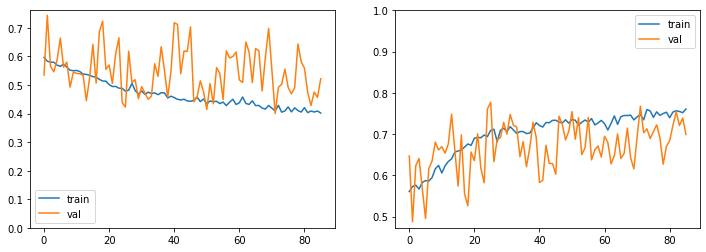

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5896 - accuracy: 0.6278 - precision: 0.9271 - recall: 0.6113 - f1: 0.7236 - specificity: 0.7289 - negative_predictive_value: 0.2474 - matthews_correlation_coefficient: 0.2431 - val_loss: 0.6356 - val_accuracy: 0.5559 - val_precision: 0.9420 - val_recall: 0.5282 - val_f1: 0.6670 - val_specificity: 0.8168 - val_negative_predictive_value: 0.2165 - val_matthews_correlation_coefficient: 0.2279

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22790, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_22-03_09_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5599 - accuracy: 0.6449 - precision: 0.9458 - recall: 0.6289 - f1: 0.7381 - specificity: 0.7712 - negative_predictive_value: 0.2755 - matthews_correlation_coefficient: 0.2913 - val_loss: 0.5889 - val_accuracy: 0.6453 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4764 - accuracy: 0.7299 - precision: 0.9551 - recall: 0.7204 - f1: 0.8160 - specificity: 0.7827 - negative_predictive_value: 0.3258 - matthews_correlation_coefficient: 0.3715 - val_loss: 0.4460 - val_accuracy: 0.7493 - val_precision: 0.9378 - val_recall: 0.7666 - val_f1: 0.8412 - val_specificity: 0.6732 - val_negative_predictive_value: 0.3121 - val_matthews_correlation_coefficient: 0.3245

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40867
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4725 - accuracy: 0.7399 - precision: 0.9534 - recall: 0.7370 - f1: 0.8259 - specificity: 0.7766 - negative_predictive_value: 0.3357 - matthews_correlation_coefficient: 0.3785 - val_loss: 0.4574 - val_accuracy: 0.7615 - val_precision: 0.9455 - val_recall: 0.7733 - val_f1: 0.8485 - val_specificity: 0.7387 - val_negative_predictive_value: 0.3370 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41802
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5389 - accuracy: 0.6954 - precision: 0.9525 - recall: 0.6829 - f1: 0.7705 - specificity: 0.7779 - negative_predictive_value: 0.3242 - matthews_correlation_coefficient: 0.3491 - val_loss: 0.4475 - val_accuracy: 0.7780 - val_precision: 0.9506 - val_recall: 0.7893 - val_f1: 0.8600 - val_specificity: 0.7284 - val_negative_predictive_value: 0.3561 - val_matthews_correlation_coefficient: 0.3917

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.41802
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4469 - accuracy: 0.7466 - precision: 0.9584 - recall: 0.7379 - f1: 0.8290 - specificity: 0.7985 - negative_predictive_value: 0.3483 - matthews_correlation_coefficient: 0.4025 - val_loss: 0.3968 - val_accuracy: 0.8083 - val_precision: 0.9431 - val_recall: 0.8334 - val_f1: 0.8822 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4130 - accuracy: 0.7748 - precision: 0.9630 - recall: 0.7690 - f1: 0.8509 - specificity: 0.8138 - negative_predictive_value: 0.3848 - matthews_correlation_coefficient: 0.4443 - val_loss: 0.3531 - val_accuracy: 0.8222 - val_precision: 0.9306 - val_recall: 0.8634 - val_f1: 0.8936 - val_specificity: 0.5961 - val_negative_predictive_value: 0.4102 - val_matthews_correlation_coefficient: 0.3855

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45585
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4176 - accuracy: 0.7729 - precision: 0.9613 - recall: 0.7680 - f1: 0.8479 - specificity: 0.8109 - negative_predictive_value: 0.3780 - matthews_correlation_coefficient: 0.4350 - val_loss: 0.3222 - val_accuracy: 0.8404 - val_precision: 0.9012 - val_recall: 0.9203 - val_f1: 0.9092 - val_specificity: 0.3811 - val_negative_predictive_value: 0.4073 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45850
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4060 - accuracy: 0.7918 - precision: 0.9571 - recall: 0.7918 - f1: 0.8631 - specificity: 0.7814 - negative_predictive_value: 0.3985 - matthews_correlation_coefficient: 0.4434 - val_loss: 0.3897 - val_accuracy: 0.7936 - val_precision: 0.9447 - val_recall: 0.8127 - val_f1: 0.8716 - val_specificity: 0.7111 - val_negative_predictive_value: 0.3795 - val_matthews_correlation_coefficient: 0.4021

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45850
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3995 - accuracy: 0.8011 - precision: 0.9616 - recall: 0.8016 - f1: 0.8710 - specificity: 0.7980 - negative_predictive_value: 0.4093 - matthews_correlation_coefficient: 0.4641 - val_loss: 0.3358 - val_accuracy: 0.8309 - val_precision: 0.9176 - val_recall: 0.8878 - val_f1: 0.9007 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46446
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3921 - accuracy: 0.7959 - precision: 0.9647 - recall: 0.7910 - f1: 0.8652 - specificity: 0.8509 - negative_predictive_value: 0.4025 - matthews_correlation_coefficient: 0.4774 - val_loss: 0.3662 - val_accuracy: 0.8205 - val_precision: 0.9389 - val_recall: 0.8514 - val_f1: 0.8912 - val_specificity: 0.6613 - val_negative_predictive_value: 0.4115 - val_matthews_correlation_coefficient: 0.4138

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46446
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4521 - accuracy: 0.7711 - precision: 0.9580 - recall: 0.7659 - f1: 0.8424 - specificity: 0.8010 - negative_predictive_value: 0.3805 - matthews_correlation_coefficient: 0.4334 - val_loss: 0.3487 - val_accuracy: 0.8456 - val_precision: 0.9450 - val_recall: 0.8762 - val_f1: 0.9077 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46526
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4023 - accuracy: 0.7889 - precision: 0.9667 - recall: 0.7835 - f1: 0.8614 - specificity: 0.8342 - negative_predictive_value: 0.4014 - matthews_correlation_coefficient: 0.4697 - val_loss: 0.2921 - val_accuracy: 0.8621 - val_precision: 0.9219 - val_recall: 0.9212 - val_f1: 0.9207 - val_specificity: 0.5199 - val_negative_predictive_value: 0.4883 - val_matthews_correlation_coefficient: 0.4155

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.46526
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3594 - accuracy: 0.8102 - precision: 0.9695 - recall: 0.8056 - f1: 0.8771 - specificity: 0.8421 - negative_predictive_value: 0.4287 - matthews_correlation_coefficient: 0.5002 - val_loss: 0.3350 - val_accuracy: 0.8326 - val_precision: 0.9261 - val_recall: 0.8808 - val_f1: 0.9011 - val_spe

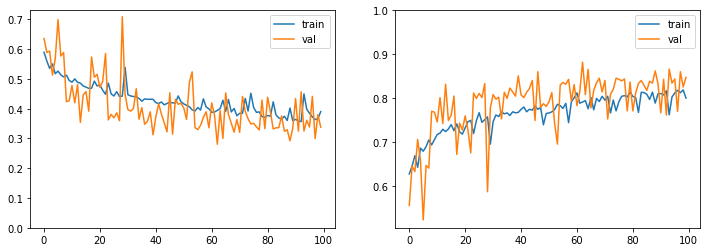

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_22-03_24_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_22-03_24_21.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_22-03_24_21.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



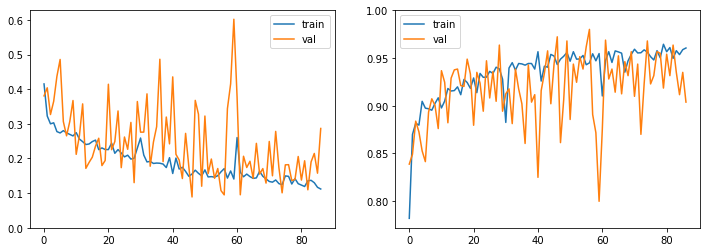

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6021 - accuracy: 0.6347 - precision: 0.8869 - recall: 0.5895 - f1: 0.6973 - specificity: 0.7759 - negative_predictive_value: 0.3994 - matthews_correlation_coefficient: 0.3228 - val_loss: 0.6772 - val_accuracy: 0.6010 - val_precision: 0.8671 - val_recall: 0.5094 - val_f1: 0.6350 - val_specificity: 0.8240 - val_negative_predictive_value: 0.3885 - val_matthews_correlation_coefficient: 0.2904

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29040, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_22-03_37_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5725 - accuracy: 0.6711 - precision: 0.8949 - recall: 0.6356 - f1: 0.7378 - specificity: 0.7809 - negative_predictive_value: 0.4219 - matthews_correlation_coefficient: 0.3625 - val_loss: 0.5904 - val_accuracy: 0.6661 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36431
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5382 - accuracy: 0.7017 - precision: 0.9068 - recall: 0.6690 - f1: 0.7656 - specificity: 0.7938 - negative_predictive_value: 0.4502 - matthews_correlation_coefficient: 0.4058 - val_loss: 0.5525 - val_accuracy: 0.6765 - val_precision: 0.8765 - val_recall: 0.6174 - val_f1: 0.7195 - val_specificity: 0.8005 - val_negative_predictive_value: 0.4435 - val_matthews_correlation_coefficient: 0.3639

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36431
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5352 - accuracy: 0.7059 - precision: 0.8974 - recall: 0.6758 - f1: 0.7653 - specificity: 0.7761 - negative_predictive_value: 0.4556 - matthews_correlation_coefficient: 0.4043 - val_loss: 0.5530 - val_accuracy: 0.6938 - val_precision: 0.8567 - val_recall: 0.6603 - val_f1: 0.7417 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37989
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5221 - accuracy: 0.7176 - precision: 0.9090 - recall: 0.6910 - f1: 0.7794 - specificity: 0.7897 - negative_predictive_value: 0.4709 - matthews_correlation_coefficient: 0.4267 - val_loss: 0.5206 - val_accuracy: 0.7190 - val_precision: 0.8573 - val_recall: 0.6973 - val_f1: 0.7654 - val_specificity: 0.7332 - val_negative_predictive_value: 0.4805 - val_matthews_correlation_coefficient: 0.3795

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37989
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5166 - accuracy: 0.7208 - precision: 0.9035 - recall: 0.6981 - f1: 0.7808 - specificity: 0.7840 - negative_predictive_value: 0.4725 - matthews_correlation_coefficient: 0.4254 - val_loss: 0.5602 - val_accuracy: 0.6921 - val_precision: 0.8654 - val_recall: 0.6502 - val_f1: 0.7386 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38015
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5070 - accuracy: 0.7297 - precision: 0.9187 - recall: 0.7001 - f1: 0.7900 - specificity: 0.8230 - negative_predictive_value: 0.4905 - matthews_correlation_coefficient: 0.4603 - val_loss: 0.5173 - val_accuracy: 0.7016 - val_precision: 0.8564 - val_recall: 0.6717 - val_f1: 0.7488 - val_specificity: 0.7377 - val_negative_predictive_value: 0.4609 - val_matthews_correlation_coefficient: 0.3585

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.38015
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5071 - accuracy: 0.7241 - precision: 0.9083 - recall: 0.6914 - f1: 0.7802 - specificity: 0.8042 - negative_predictive_value: 0.4846 - matthews_correlation_coefficient: 0.4411 - val_loss: 0.5095 - val_accuracy: 0.7216 - val_precision: 0.8540 - val_recall: 0.7060 - val_f1: 0.7704 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38090
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4939 - accuracy: 0.7393 - precision: 0.9052 - recall: 0.7146 - f1: 0.7947 - specificity: 0.7958 - negative_predictive_value: 0.4942 - matthews_correlation_coefficient: 0.4563 - val_loss: 0.5759 - val_accuracy: 0.6687 - val_precision: 0.8802 - val_recall: 0.6022 - val_f1: 0.7114 - val_specificity: 0.8108 - val_negative_predictive_value: 0.4327 - val_matthews_correlation_coefficient: 0.3578

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.38090
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4887 - accuracy: 0.7267 - precision: 0.9177 - recall: 0.6948 - f1: 0.7865 - specificity: 0.8075 - negative_predictive_value: 0.4796 - matthews_correlation_coefficient: 0.4463 - val_loss: 0.5100 - val_accuracy: 0.7155 - val_precision: 0.8647 - val_recall: 0.6857 - val_f1: 0.7605 - val_spe


Epoch 00074: val_matthews_correlation_coefficient improved from 0.38647 to 0.39354, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_22-03_37_23.h5
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4860 - accuracy: 0.7377 - precision: 0.9098 - recall: 0.7125 - f1: 0.7940 - specificity: 0.8116 - negative_predictive_value: 0.4959 - matthews_correlation_coefficient: 0.4600 - val_loss: 0.5639 - val_accuracy: 0.6904 - val_precision: 0.8837 - val_recall: 0.6286 - val_f1: 0.7317 - val_specificity: 0.8129 - val_negative_predictive_value: 0.4504 - val_matthews_correlation_coefficient: 0.3822

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.39354
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4871 - accuracy: 0.7384 - precision: 0.9155 - recall: 0.7138 - f1: 0.7973 - specificity: 0.7953 - negative_predictive_value: 0.4870 - matthews_correlation_coefficient: 0.4518 - val_loss: 0.5021 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4702 - accuracy: 0.7471 - precision: 0.9140 - recall: 0.7169 - f1: 0.7995 - specificity: 0.8223 - negative_predictive_value: 0.5062 - matthews_correlation_coefficient: 0.4734 - val_loss: 0.5920 - val_accuracy: 0.6644 - val_precision: 0.8902 - val_recall: 0.5884 - val_f1: 0.7045 - val_specificity: 0.8315 - val_negative_predictive_value: 0.4292 - val_matthews_correlation_coefficient: 0.3644

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.39907
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4773 - accuracy: 0.7362 - precision: 0.9163 - recall: 0.7119 - f1: 0.7952 - specificity: 0.8150 - negative_predictive_value: 0.4944 - matthews_correlation_coefficient: 0.4650 - val_loss: 0.5315 - val_accuracy: 0.6973 - val_precision: 0.8702 - val_recall: 0.6542 - val_f1: 0.7424 - val_specificity: 0.7736 - val_negative_predictive_value: 0.4558 - val_matthews_correlation_coefficie

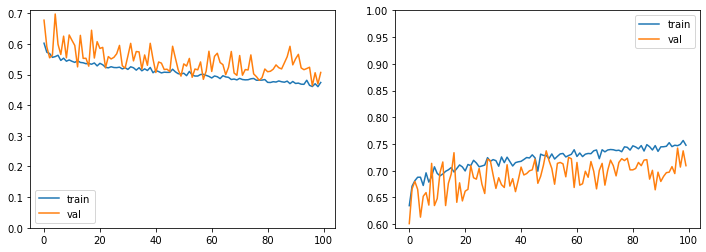

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4687 - accuracy: 0.7657 - precision: 0.9969 - recall: 0.7673 - f1: 0.8585 - specificity: 0.2460 - negative_predictive_value: 0.0464 - matthews_correlation_coefficient: 0.0857 - val_loss: 0.3092 - val_accuracy: 0.8794 - val_precision: 0.9991 - val_recall: 0.8824 - val_f1: 0.9362 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0829 - val_matthews_correlation_coefficient: 0.1324

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.13242, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_22-03_52_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3580 - accuracy: 0.8239 - precision: 0.9985 - recall: 0.8241 - f1: 0.9003 - specificity: 0.2552 - negative_predictive_value: 0.0468 - matthews_correlation_coefficient: 0.0906 - val_loss: 0.2361 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2741 - accuracy: 0.8334 - precision: 0.9995 - recall: 0.8331 - f1: 0.9072 - specificity: 0.2862 - negative_predictive_value: 0.0571 - matthews_correlation_coefficient: 0.1138 - val_loss: 0.4424 - val_accuracy: 0.7884 - val_precision: 0.9990 - val_recall: 0.7926 - val_f1: 0.8820 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0457 - val_matthews_correlation_coefficient: 0.0905

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.13273
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2826 - accuracy: 0.8230 - precision: 0.9992 - recall: 0.8230 - f1: 0.9008 - specificity: 0.2897 - negative_predictive_value: 0.0599 - matthews_correlation_coefficient: 0.1159 - val_loss: 0.4263 - val_accuracy: 0.7832 - val_precision: 0.9990 - val_recall: 0.7874 - val_f1: 0.8787 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0426 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2482 - accuracy: 0.8386 - precision: 0.9997 - recall: 0.8380 - f1: 0.9099 - specificity: 0.3000 - negative_predictive_value: 0.0577 - matthews_correlation_coefficient: 0.1182 - val_loss: 0.2086 - val_accuracy: 0.8925 - val_precision: 0.9991 - val_recall: 0.8951 - val_f1: 0.9433 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0815 - val_matthews_correlation_coefficient: 0.1312

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.13273
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2341 - accuracy: 0.8538 - precision: 0.9995 - recall: 0.8536 - f1: 0.9198 - specificity: 0.2690 - negative_predictive_value: 0.0666 - matthews_correlation_coefficient: 0.1208 - val_loss: 0.4216 - val_accuracy: 0.7858 - val_precision: 0.9990 - val_recall: 0.7899 - val_f1: 0.8802 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0420 - val_matthews_correlation_coefficie

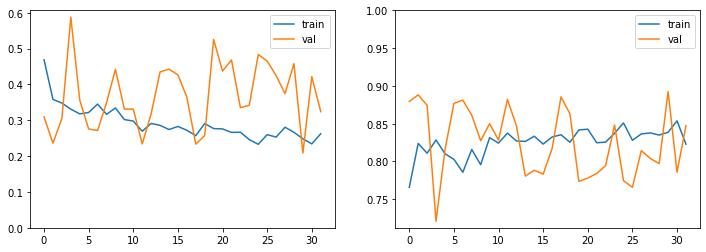

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_21-23_32_16.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_21-23_47_02.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_22-00_01_42.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_22-00_16_20.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_22-00_25_49.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_22-00_34_27.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_22-00_42_11.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_22-00_56_53.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_22-01_09_40.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_22-01_24_25.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_22-01_31_36.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_22-01_46_23.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_22-02_05_39.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\AR_FDB_m-071-3.png
1 of 1


[array([[0.999997]], dtype=float32),
 array([[0.59548616]], dtype=float32),
 array([[0.9619858]], dtype=float32),
 array([[0.9956736]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99608326]], dtype=float32),
 array([[0.90452987]], dtype=float32),
 array([[0.38736102]], dtype=float32),
 array([[0.36340058]], dtype=float32),
 array([[0.81798804]], dtype=float32),
 array([[0.99917895]], dtype=float32),
 array([[0.6577063]], dtype=float32),
 array([[0.99984527]], dtype=float32),
 array([[0.7380149]], dtype=float32),
 array([[0.7816485]], dtype=float32),
 array([[0.18203723]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.815123]], dtype=float32),
 array([[0.9995189]], dtype=float32),
 array([[0.89266235]], dtype=float32),
 array([[0.06512685]], dtype=float32),
 array([[0.99930525]], dtype=float32)]